# Norification

TODO:     追加、修正が必要\
FIXME:    既知の不具合があり、修正が必要\
HACK:     リファクタリングが必要\
XXX:      なぜ動作するか分からない\
REVIEW:   意図通りの動作か見直す必要\
OPTIMIZE: 無駄が多く、ボトルネック\
CHANGED:  コードの変更履歴\
NOTE:     なぜそのコードになったかを付記\
WARNING:  注意

# Imports

In [1]:
# standard library
import glob
import math
import os
import pathlib
import random
import sys
import warnings

# third party
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from scipy import stats
from sklearn import preprocessing

# local
import formatting as fmt

# Initial settings

### warnings

In [2]:
# dfを表示する際の最大行/列数を指定します
# これによってdfが見やすくなります
# pl.options.display.max_rows = 10
# pl.options.display.max_columns = None

# 余計な警告表示をなくしてくれます
warnings.filterwarnings('ignore')

### colors

In [3]:
# Color palette
color_slf  = ['darkslategray', 'mediumseagreen', 'lime']
# color_slf  = ['mediumseagreen' for _ in range(3)]
color_obs  = ['darkblue',      'cornflowerblue', 'cyan']
# color_obs  = ['cornflowerblue' for _ in range(3)] 
color_test = ['maroon',        'orange',         'gold']
# color_test  = ['orange' for _ in range(3)]
colors = [color_slf[1], color_obs[1], color_test[1]]

### labels

In [4]:
cols = ['game_No', 'seq_No',
        'block', 'seq_pattern','loc_pattern',
        'loc_left', 'loc_right', 'sd', 'pt', 'conf', 'reward',
        't_choice', 't_conf', 'idx_left', 'idx_right',
        'img_choice', 'img_correct', 'loc_choice',
        't_choice_pres', 't_choice_resp',
        't_conf_pres',   't_conf_resp',
        't_reward_pres', 't_reward_resp']

pat_label = ['S - O - T', 'O - S - T']
seq_label = ['slf', 'obs', 'test']
pair_label = ['30/40', '40/50', '50/30']

# Load Data 

In [5]:
individual = fmt.generate_individual_data_instance()

In [6]:
len(individual)

16

In [7]:
# HACK: pl.cloneで書き直す -> DONE
class Integrated:
    """全被験者の結果を結合したdfを取得するためのクラス
    """
    def __init__(self, individual, pat):
        self.slf = individual[1][pat].slf.clone()
        self.obs = individual[1][pat].obs.clone()
        self.test = individual[1][pat].test.clone()
        
        for subj in range(2, 16):
            self.slf = pl.concat([self.slf, individual[subj][pat].slf.clone()])
            self.obs = pl.concat([self.obs, individual[subj][pat].obs.clone()])
            self.test = pl.concat([self.test, individual[subj][pat].test.clone()])

integrated = [0]
integrated.append(Integrated(individual, 1))
integrated.append(Integrated(individual, 2))

In [8]:

# loc_left_exp_key, loc_right_exp_key, img_correct_exp_key, pt_exp_key\
#     = 'loc_left_exp', 'loc_right_exp', 'img_correct_exp', 'pt_exp'

# 主にグラフのラベル用のリストです
xlim_slf, xlim_obs, xlim_test    = 36, 36, 90
xstep_slf, xstep_obs, xstep_test = 12, 12, 30
ylim_img, ylim_conf = 5.0, 3.0
num_list     = [1, 2, 3]
loc_list     = [30, 40, 50]
seq_label1   = ['Self', 'Observation', 'Test']
seq_label2   = ['Observation', 'Self', 'Test']
type_label   = ['slf', 'obs', 'test']
choice_label = ['S_choice', 'O_choice', 'T_choice']
conf_label   = ['S_conf', 'O_conf', 'T_conf']
block_label  = ['_1st', '_2nd', '_3rd']
S_seq_label  = ['S' + i for i in block_label]
O_seq_label  = ['O' + i for i in block_label]
T_seq_label  = ['T' + i for i in block_label]

img_prefix = 'img/'
img_suffix = '.png'


# Reaction Time

### through tha Game

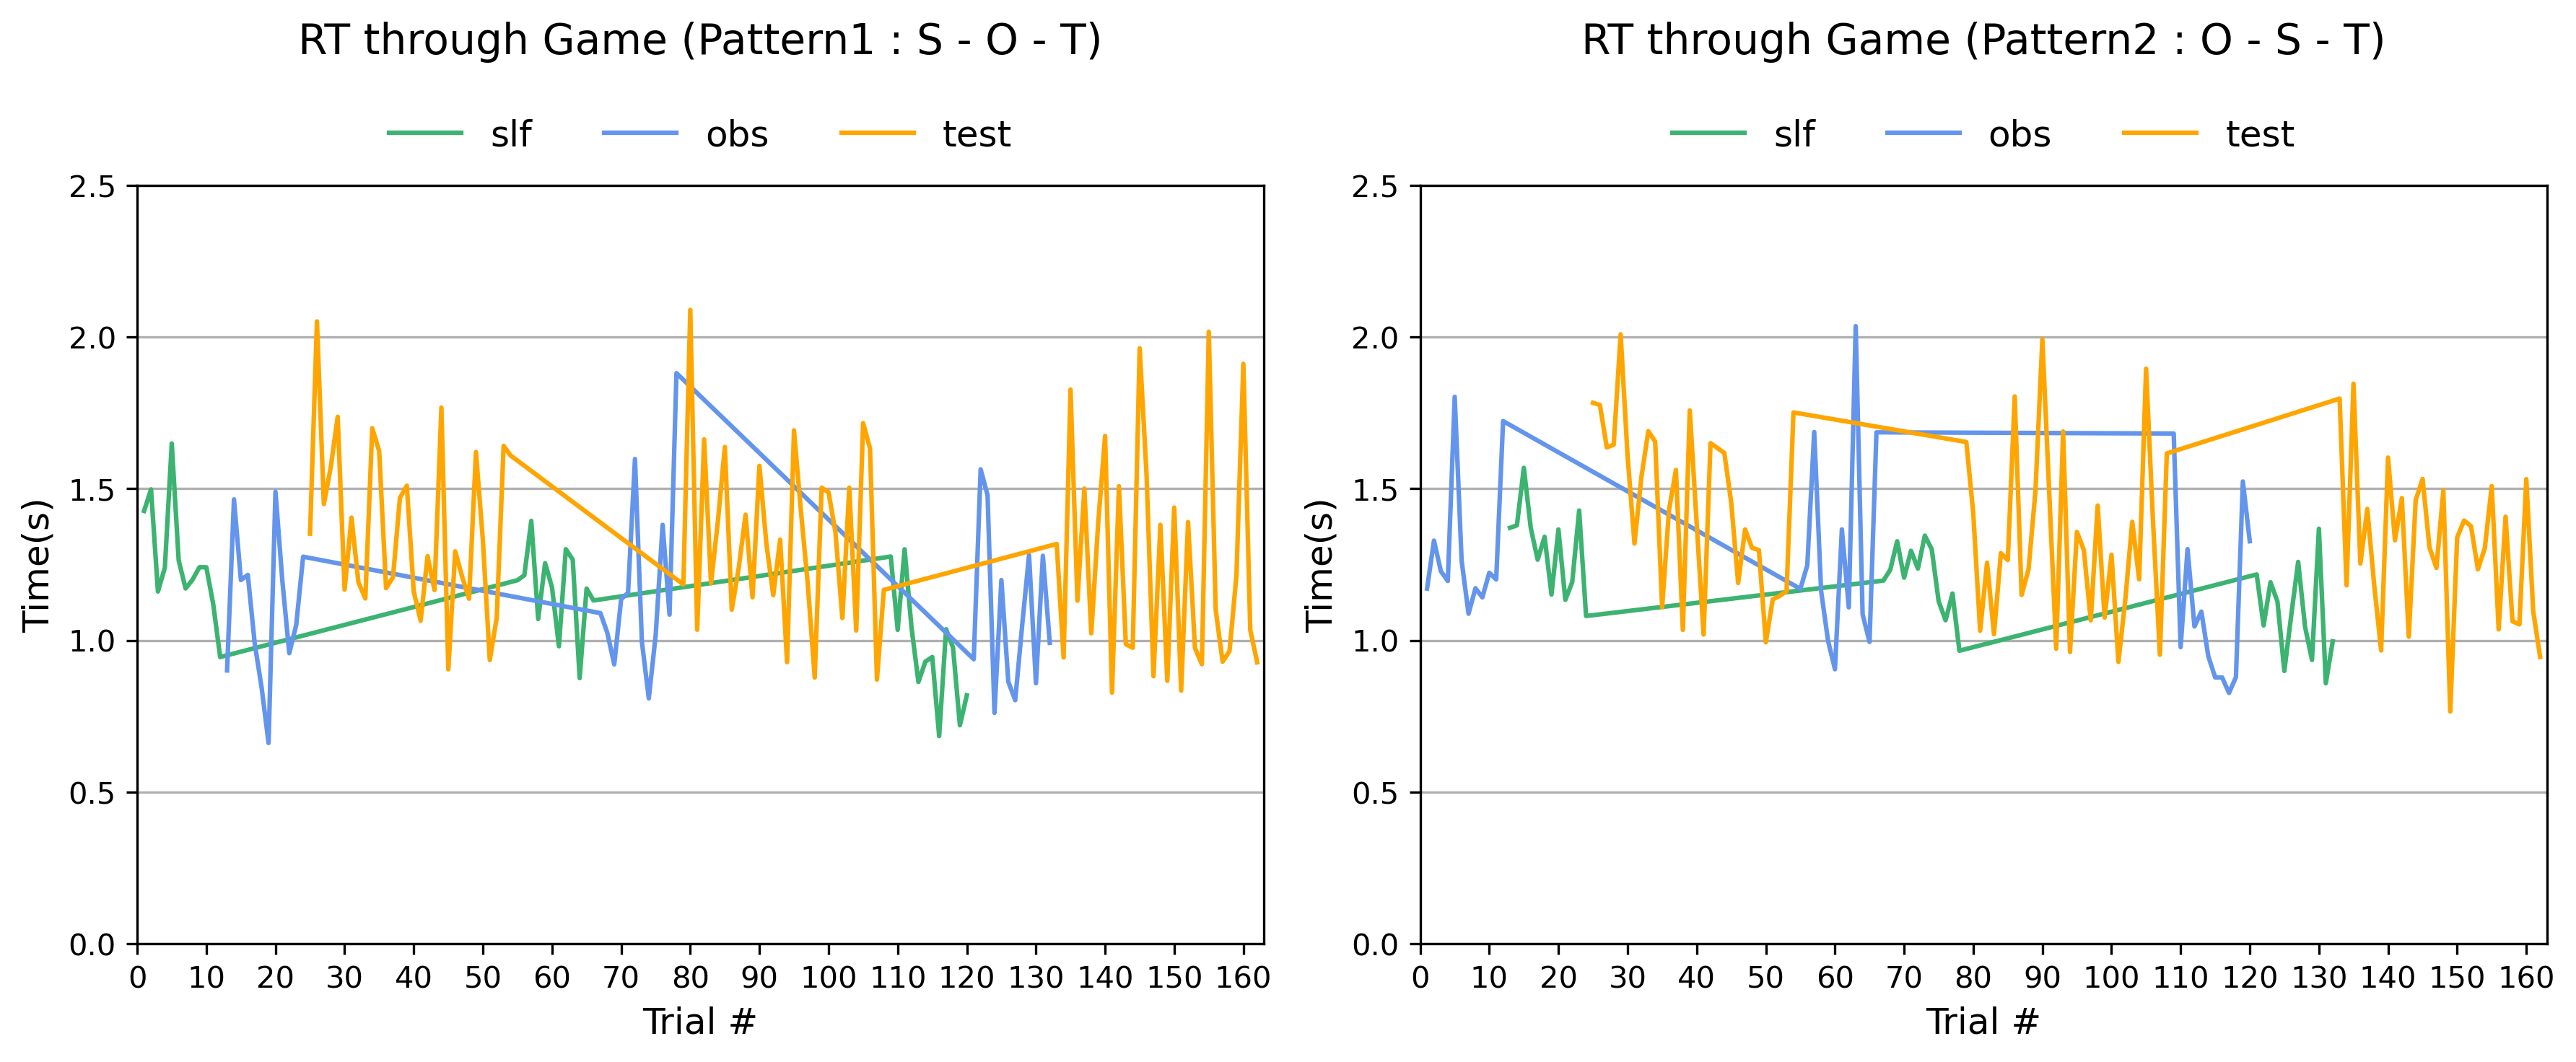

In [9]:
def rt_through_game(ax, df, seq, color, pat):
    df = df.select(pl.col('game_No', 't_choice')).groupby('game_No').mean().sort(by='game_No')
    
    ax.plot(df.get_column('game_No'),
            df.get_column('t_choice'),
            label=seq,
            # width=.5,
            color=color
            )
    ax.set_xlim(0, -~xlim)
    ax.set_ylim(0, ylim)
    ax.set_xticks(np.arange(0, 165, step=10))
    ax.set_yticks(np.arange(0, ylim+.1, .5))
    ax.set_xlabel('Trial #', fontsize=12)
    ax.set_ylabel('Time(s)', fontsize=12)

    ax.set_title(f'RT through Game (Pattern{pat} : {pat_label[pat-1]})', y=1.15, fontsize=14)
    ax.grid(axis='y')
    ax.legend(loc='lower center', bbox_to_anchor=(.5,1), ncol=3, frameon=False, fontsize=12)


xlim = 162
ylim = 2.5
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=300, tight_layout=True, sharey=False)

for pat in range(1, 3):
    rt_through_game(ax[pat-1], integrated[pat].slf, seq_label[0], colors[0], pat)
    rt_through_game(ax[pat-1], integrated[pat].obs, seq_label[1], colors[1], pat)
    rt_through_game(ax[pat-1], integrated[pat].test, seq_label[2], colors[2], pat)


### Each Sequence (Slf: 36 trials, Obs: 36 trials, Test: 90 trials)

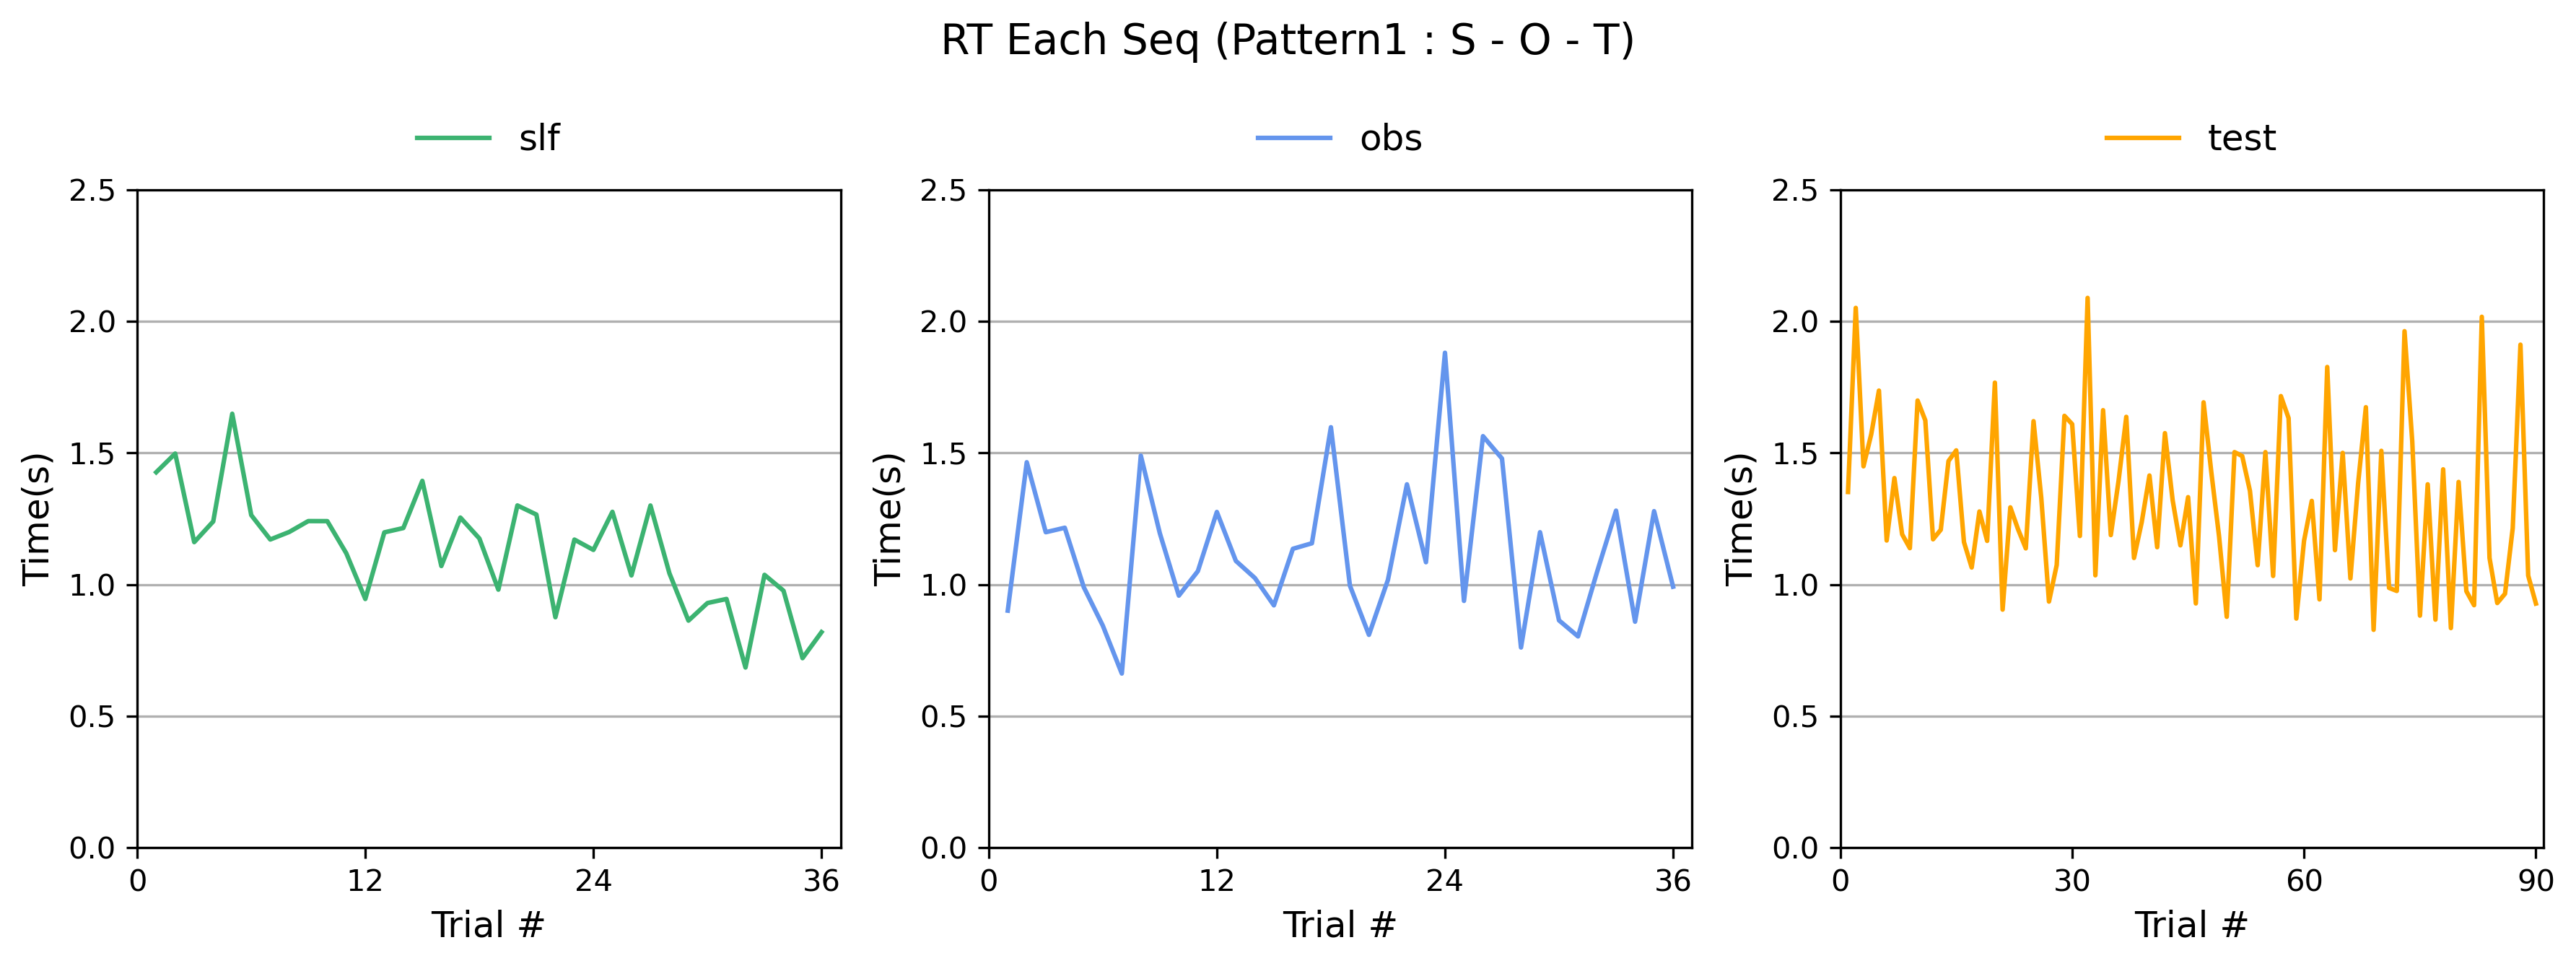

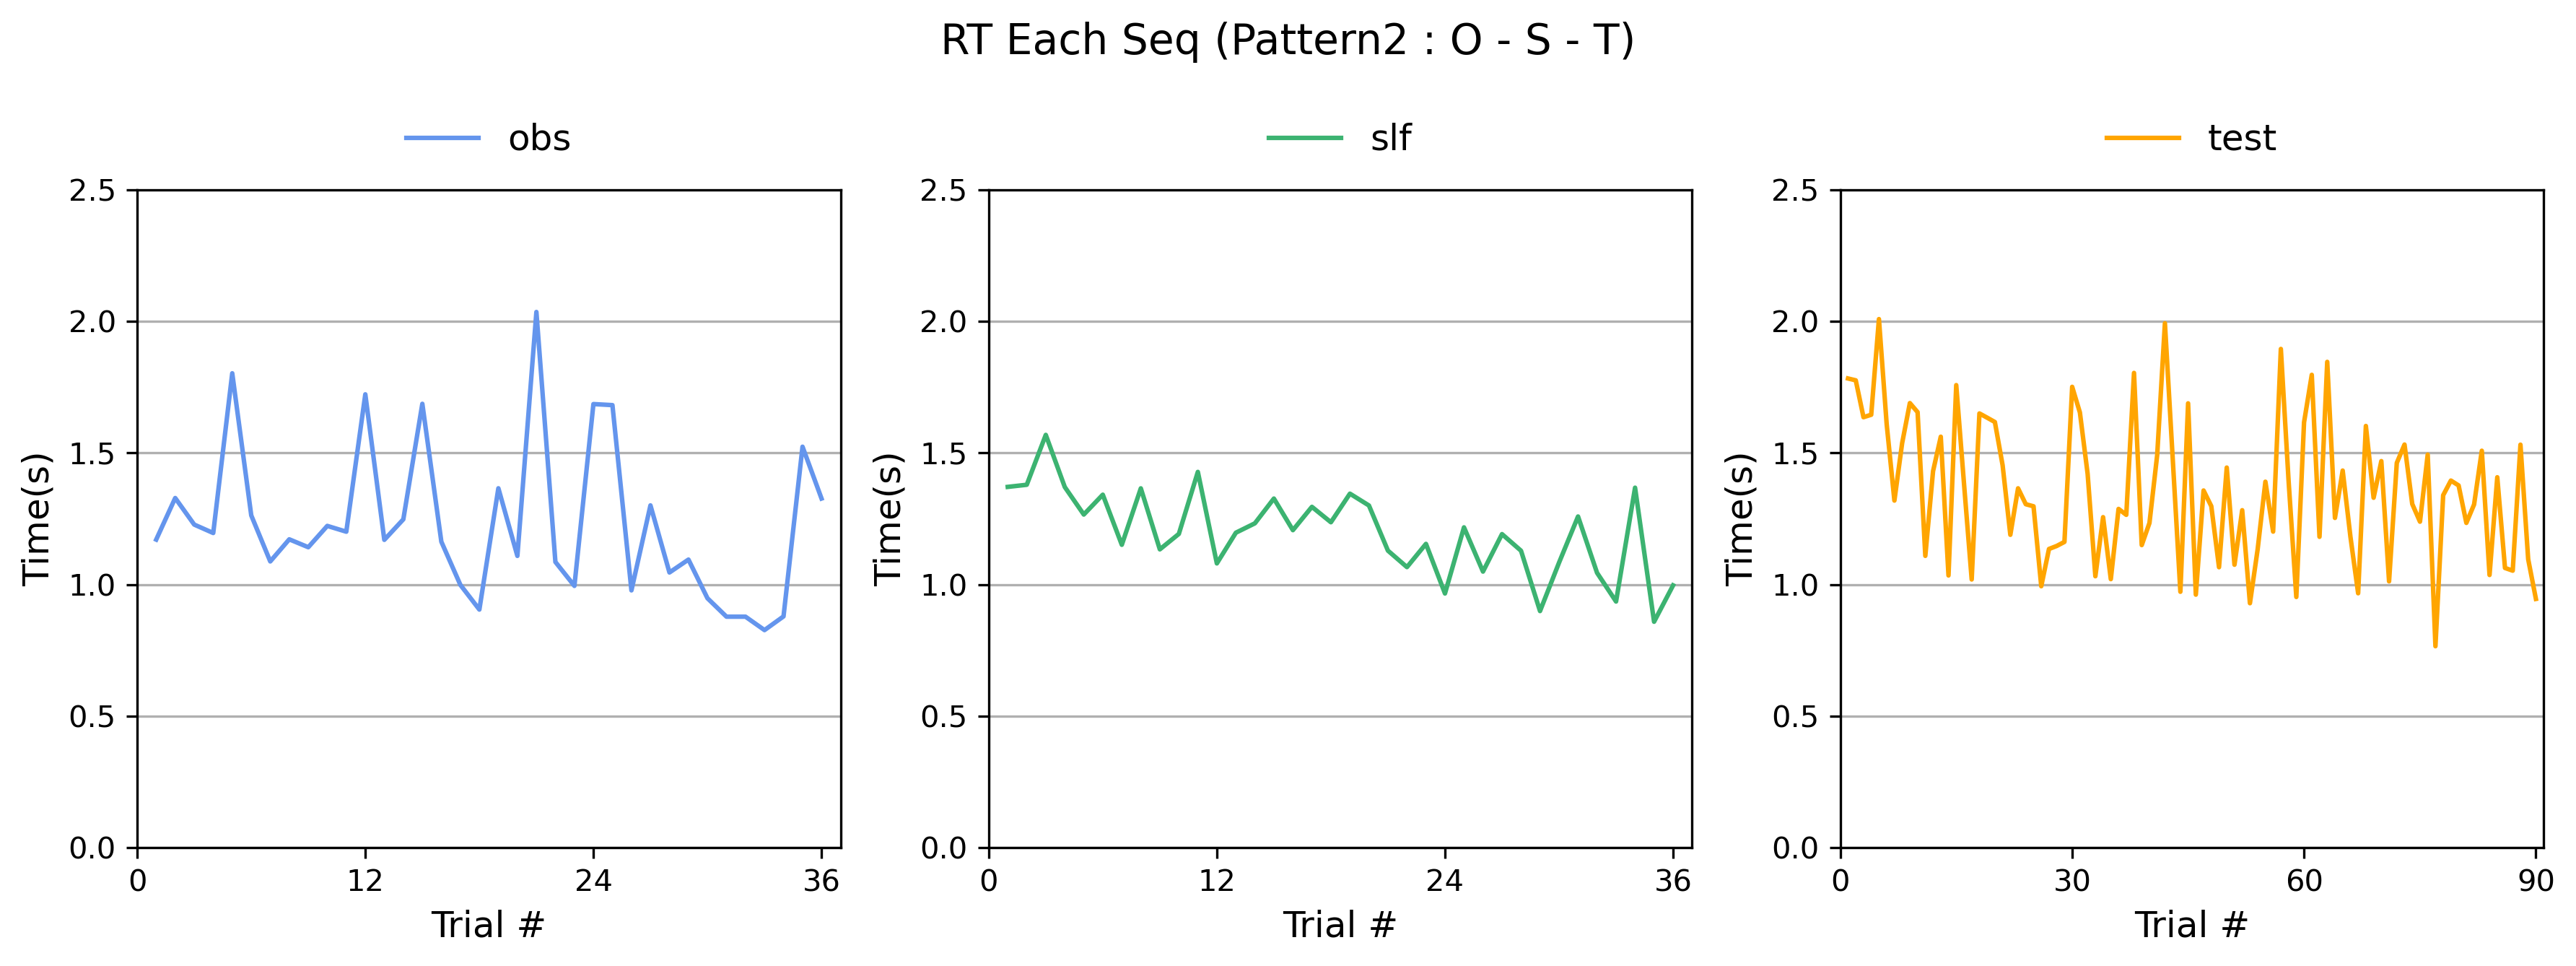

In [10]:
def rt_each_seq(ax, df, seq, color, xlim, ylim):
    df = df.select(pl.col('seq_No', 't_choice')).groupby('seq_No').mean().sort(by='seq_No')
    
    ax.plot(df.get_column('seq_No'),
            df.get_column('t_choice'),
            label=seq,
            # width=.5,
            color=color
            )
    
    ax.set_xlim(0, -~xlim)
    ax.set_ylim(0, ylim)
    ax.set_xticks(np.arange(0, -~xlim, step=xlim//3))
    ax.set_yticks(np.arange(0, ylim+.1, .5))
    ax.set_xlabel('Trial #', fontsize=12)
    ax.set_ylabel('Time(s)', fontsize=12)

    # ax.set_title(seq, y=1.15, fontsize=14)
    ax.grid(axis='y')
    ax.legend(loc='lower center', bbox_to_anchor=(.5,1), ncol=3, frameon=False, fontsize=12)


xlim_so = 36
xlim_t = 90
ylim = 2.5

for pat in range(1, 3):
    s, o = (0, 1) if pat==1 else (1, 0)
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5), dpi=300, tight_layout=True, sharey=False)
    
    rt_each_seq(ax[s], integrated[pat].slf, seq_label[0], colors[0], xlim_so, ylim)
    rt_each_seq(ax[o], integrated[pat].obs, seq_label[1], colors[1], xlim_so, ylim)
    rt_each_seq(ax[2], integrated[pat].test, seq_label[2], colors[2], xlim_t, ylim)
    
    plt.suptitle(f'RT Each Seq (Pattern{pat} : {pat_label[pat-1]})', fontsize=14)

### Each Pair

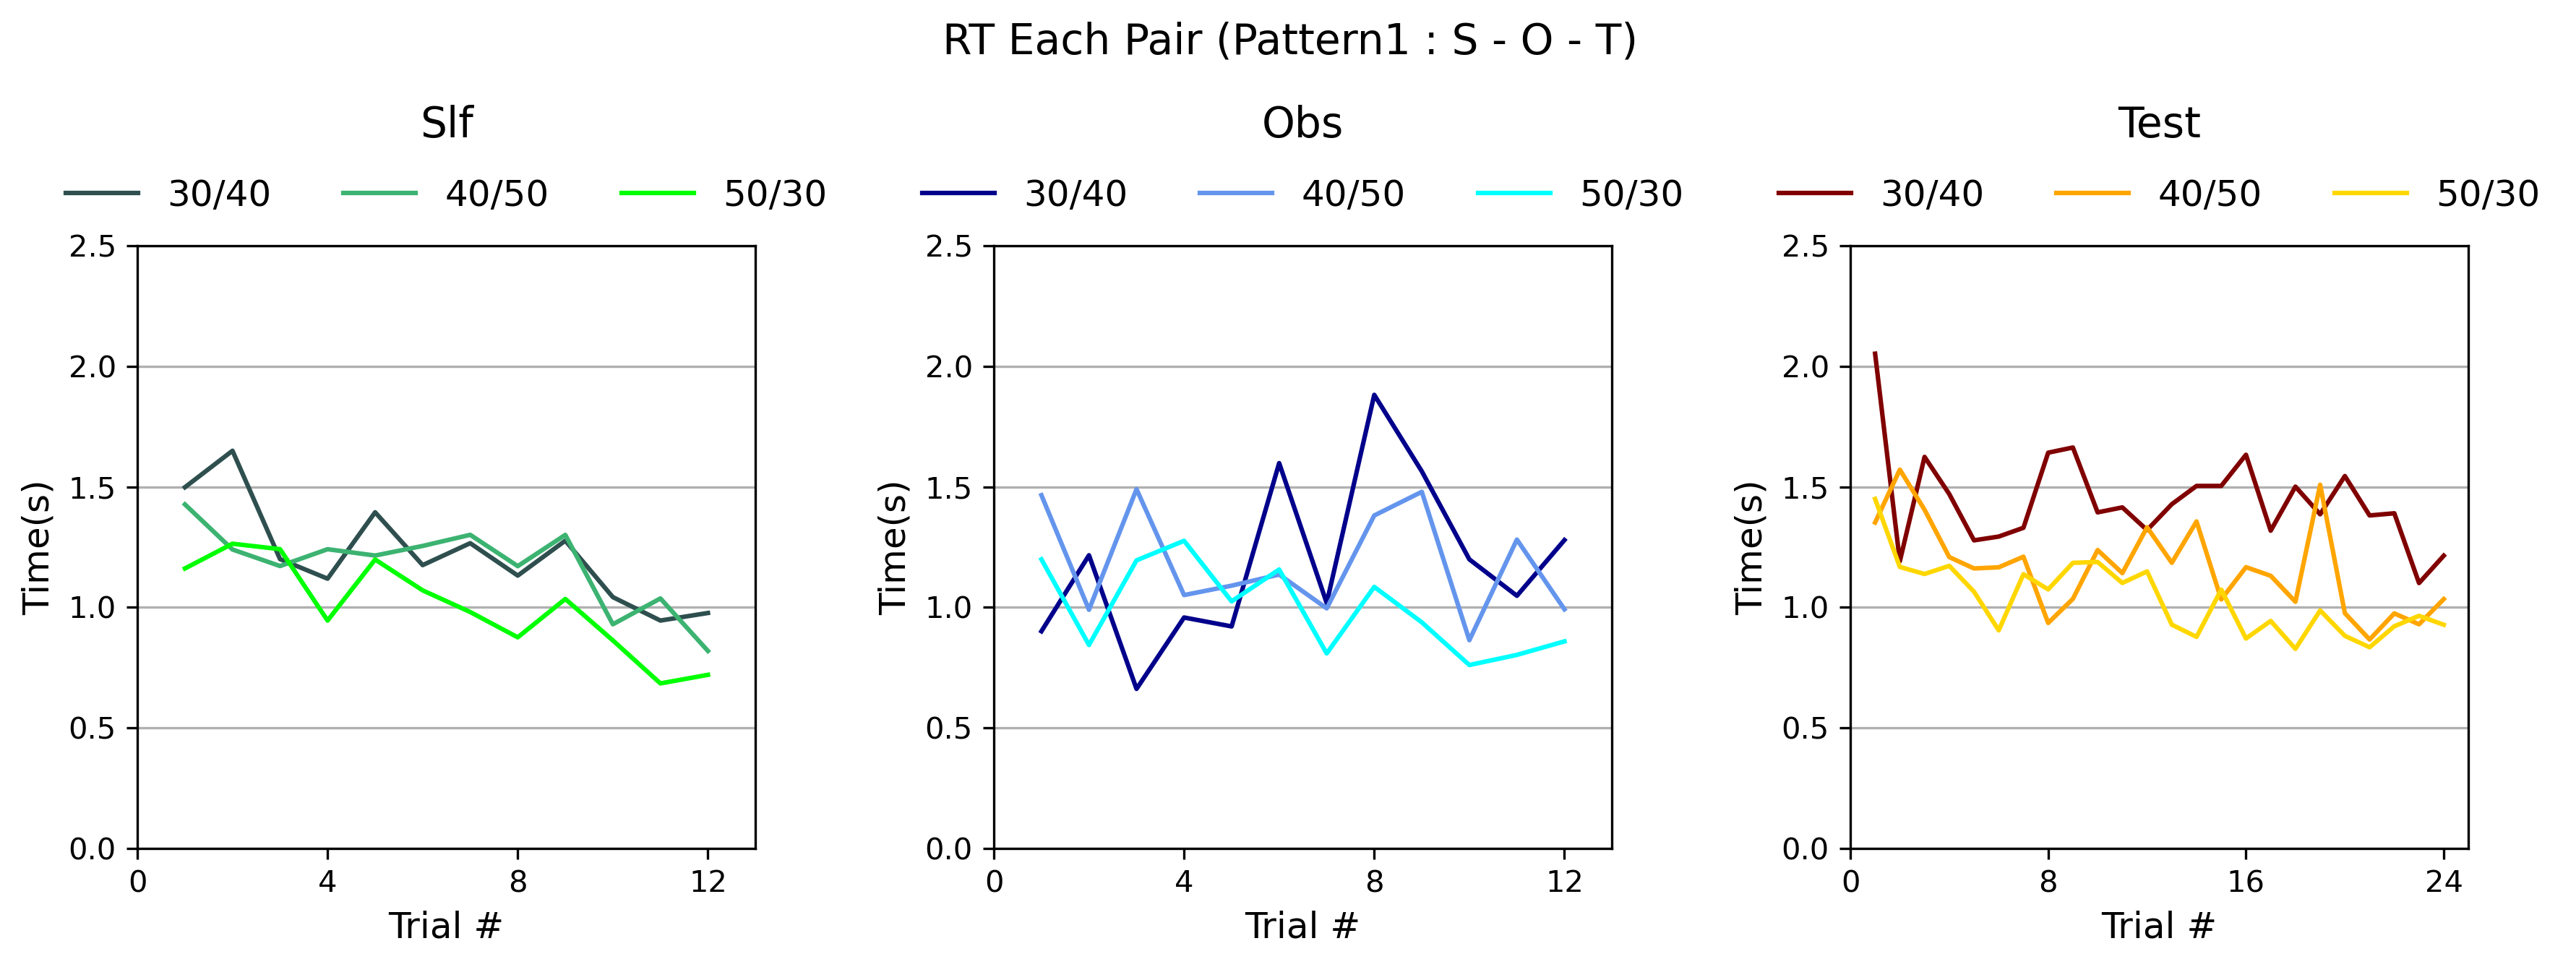

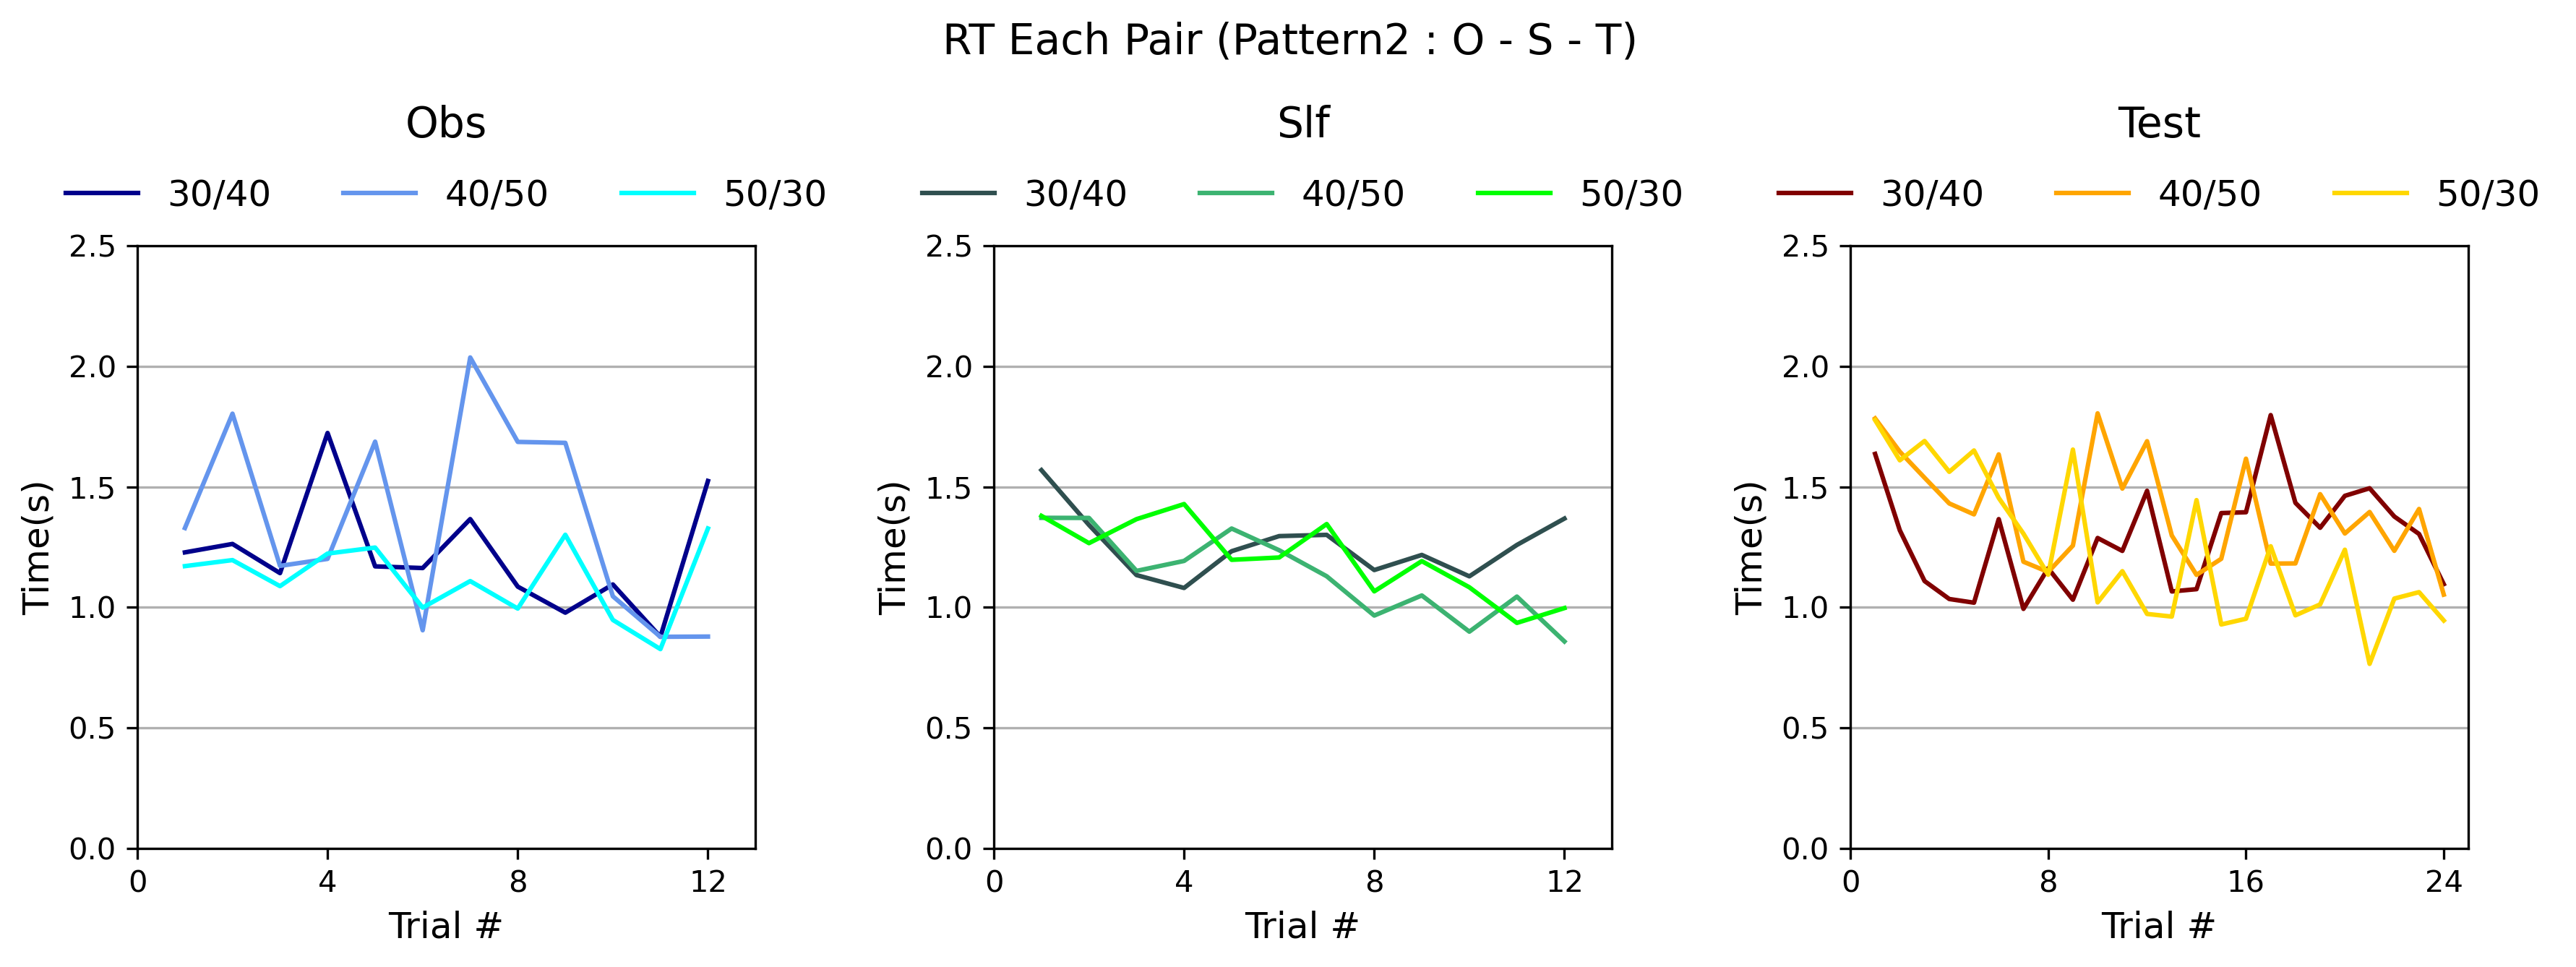

In [11]:
def rt_each_pair(ax, df, seq, pair, color, xlim, ylim):
    df = df.select(pl.col('seq_No', 'loc_pattern', 't_choice')).groupby('seq_No', 'loc_pattern')\
        .mean().sort(by='seq_No')
        
    df1 = df.filter(pl.col('loc_pattern')==1).with_row_count().with_columns(pl.col('row_nr') + 1)
    df2 = df.filter(pl.col('loc_pattern')==2).with_row_count().with_columns(pl.col('row_nr') + 1)
    df3 = df.filter(pl.col('loc_pattern')==3).with_row_count().with_columns(pl.col('row_nr') + 1)
    
    for i, df_ in enumerate([df1, df2, df3]):
        ax.plot(df_.get_column('row_nr'),
                df_.get_column('t_choice'),
                label=pair[i],
                # width=.5,
                color=color[i]
                )
    
    ax.set_xlim(0, xlim+1)
    ax.set_ylim(0, ylim)
    ax.set_xticks(np.arange(0, xlim+.1, step=xlim//3))
    ax.set_yticks(np.arange(0, ylim+.1, .5))
    ax.set_xlabel('Trial #', fontsize=12)
    ax.set_ylabel('Time(s)', fontsize=12)

    ax.set_title(seq, y=1.15, fontsize=14)
    ax.grid(axis='y')
    ax.legend(loc='lower center', bbox_to_anchor=(.5,1), ncol=3, frameon=False, fontsize=12)


xlim_so = 12
xlim_t = 24 # 30/30, 40/40, 50/50は省いている
ylim = 2.5

for pat in range(1, 3):
    s, o = (0, 1) if pat==1 else (1, 0)
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5), dpi=300, tight_layout=True, sharey=False)
    
    rt_each_pair(ax[s], integrated[pat].slf, 'Slf', pair_label, color_slf, xlim_so, ylim)
    # rt_each_pair(ax[s][1], integrated[pat].slf.filter(pl.col('loc_pattern')==2), pair_label[1], color_obs, xlim_so, ylim)
    # rt_each_pair(ax[s][2], integrated[pat].slf.filter(pl.col('loc_pattern')==3), pair_label[2], color_test, xlim_so, ylim)

    rt_each_pair(ax[o], integrated[pat].obs, 'Obs', pair_label, color_obs, xlim_so, ylim)
    # rt_each_pair(ax[o][1], integrated[pat].obs.filter(pl.col('loc_pattern')==2), pair_label[1], colors[1], xlim_so, ylim)
    # rt_each_pair(ax[o][2], integrated[pat].obs.filter(pl.col('loc_pattern')==3), pair_label[2], colors[1], xlim_so, ylim)

    rt_each_pair(ax[2], integrated[pat].test, 'Test', pair_label, color_test, xlim_t, ylim)
    # rt_each_pair(ax[2][1], integrated[pat].test.filter(pl.col('loc_pattern')==2), pair_label[1], colors[2], xlim_t, ylim)
    # rt_each_pair(ax[2][2], integrated[pat].test.filter(pl.col('loc_pattern')==3), pair_label[2], colors[2], xlim_t, ylim)
    
    plt.suptitle(f'RT Each Pair (Pattern{pat} : {pat_label[pat-1]})', fontsize=14)

### Each Condition in Test (SS, OO, SO) 

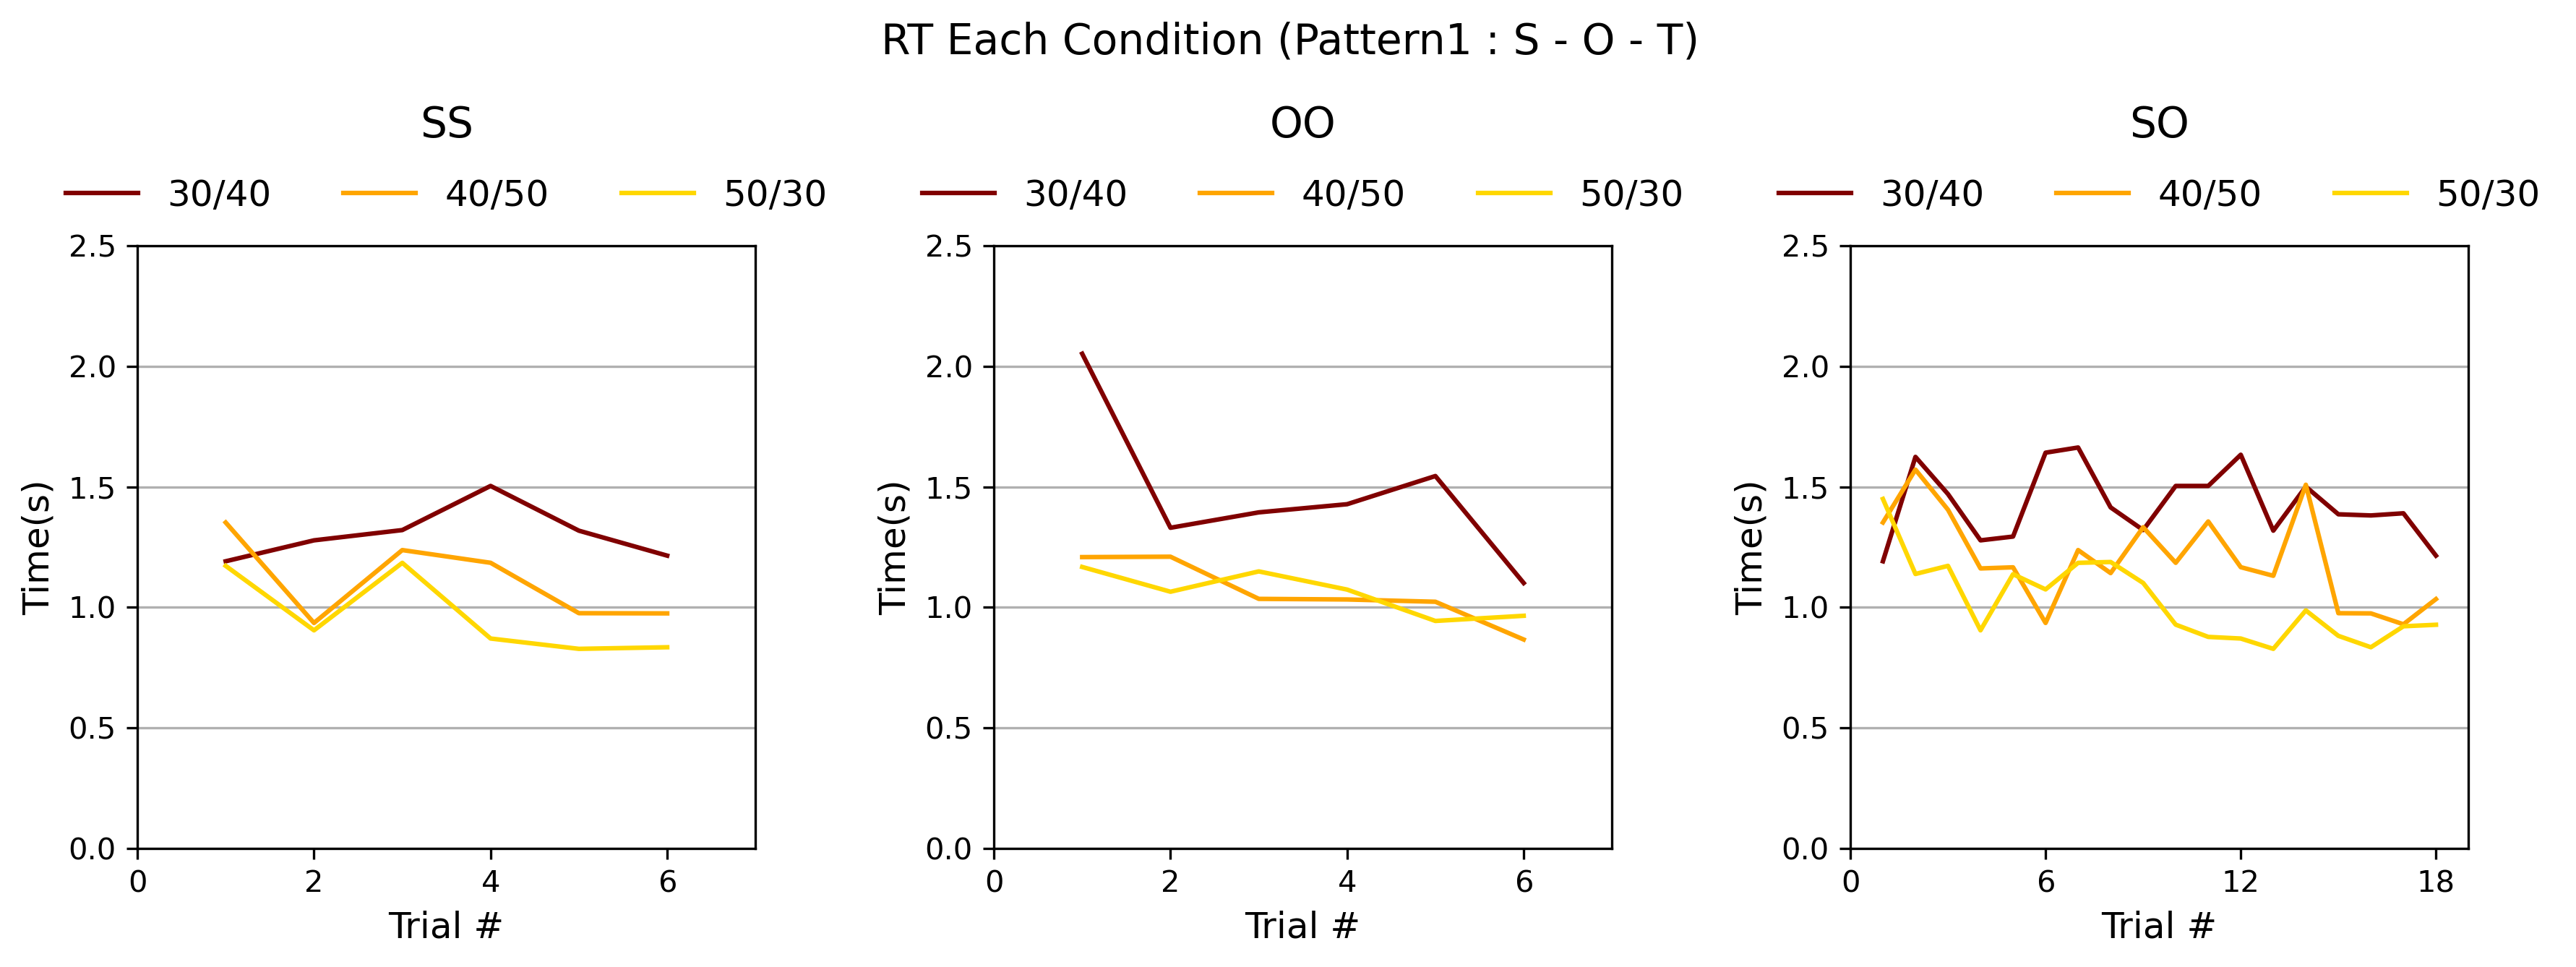

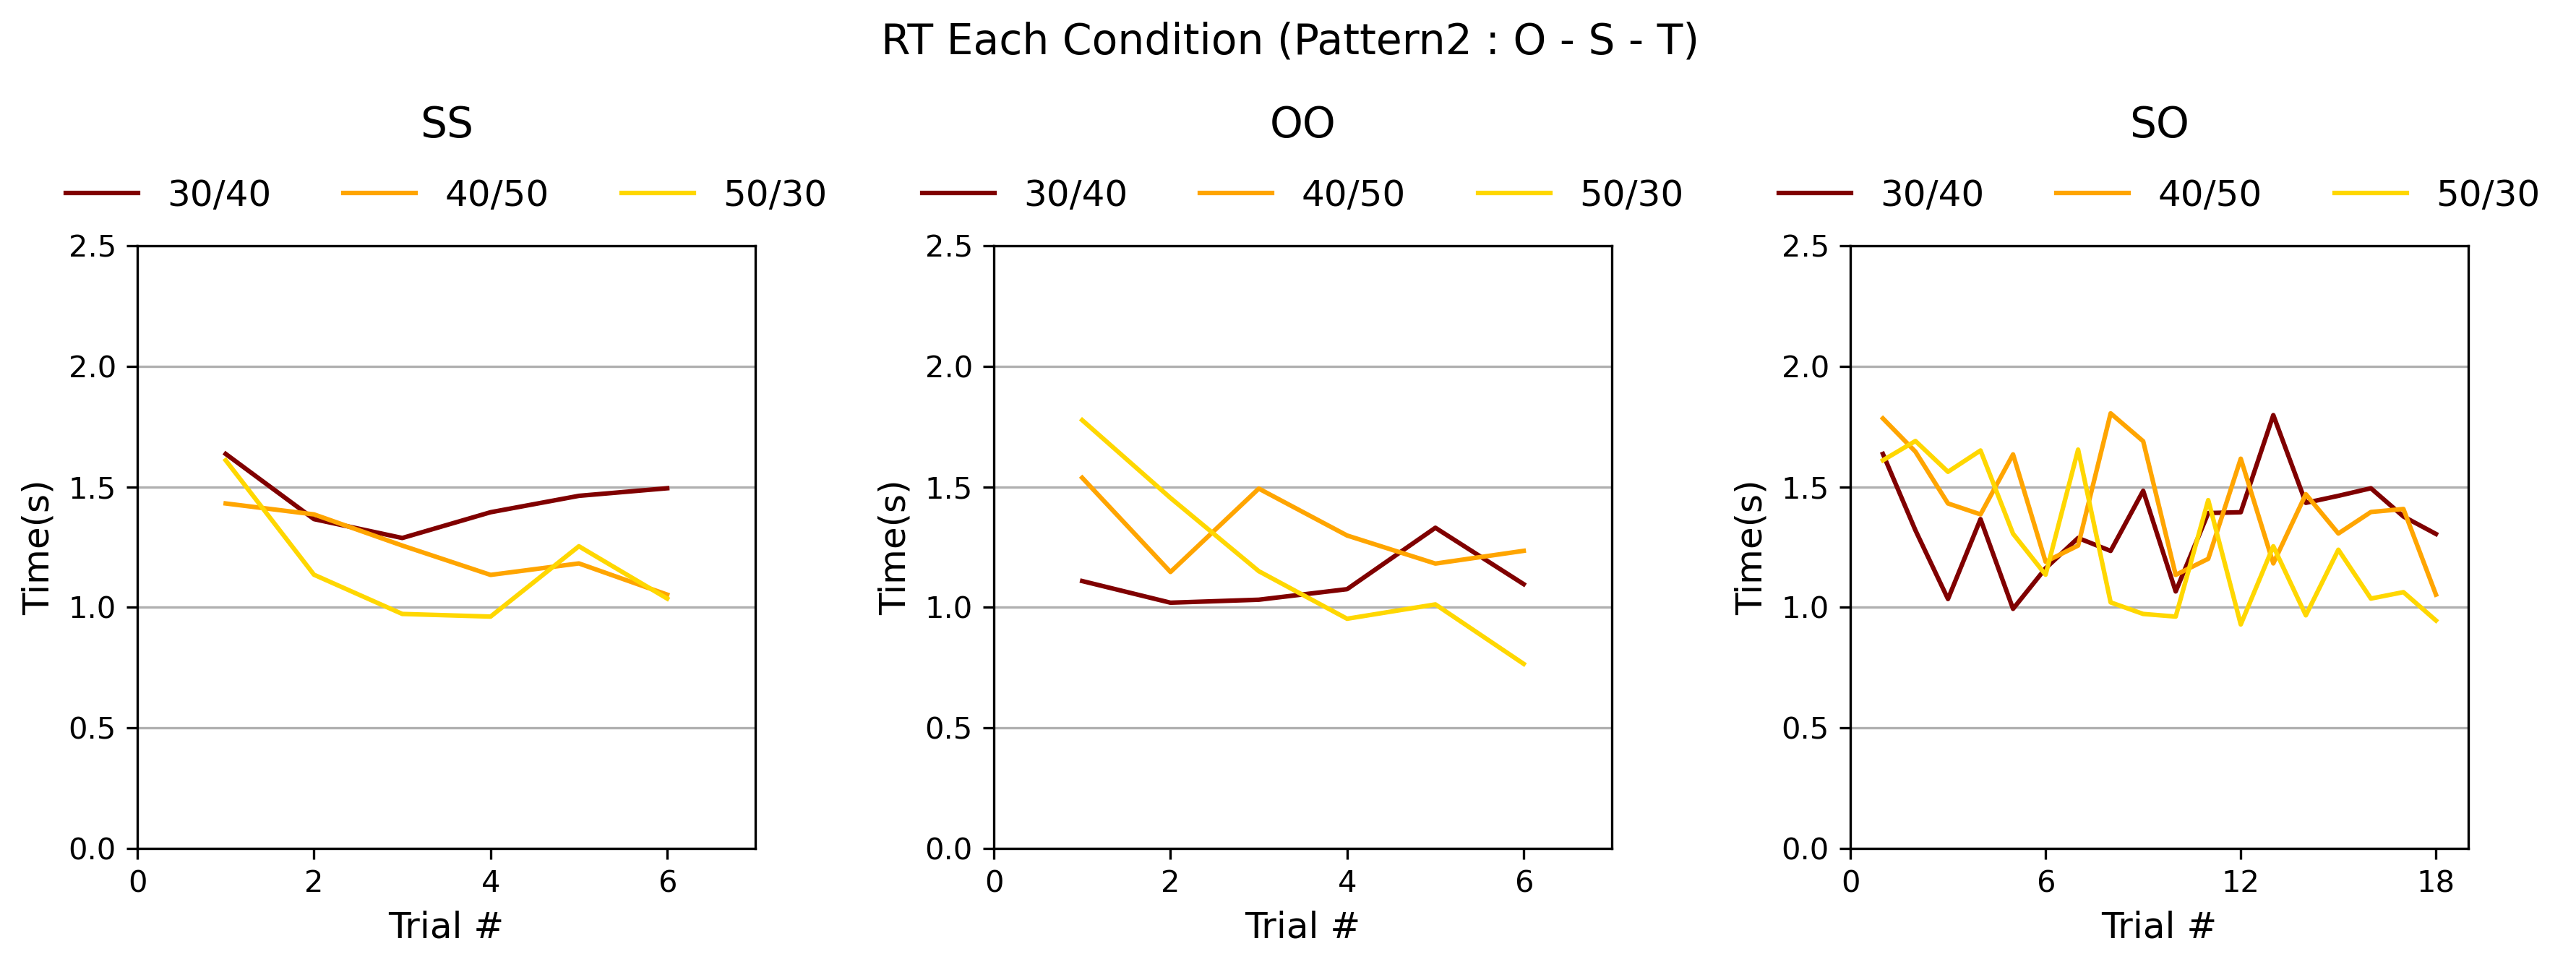

In [12]:
def rt_each_cond(ax, df, cond, pair, width, color, alpha, xlim, ylim):
    df = df.select(pl.col('seq_No', 'loc_pattern', 't_choice')).groupby('seq_No', 'loc_pattern')\
        .mean().sort(by='seq_No')

    df1 = df.filter(pl.col('loc_pattern')==1).with_row_count().with_columns(pl.col('row_nr') + 1)
    df2 = df.filter(pl.col('loc_pattern')==2).with_row_count().with_columns(pl.col('row_nr') + 1)
    df3 = df.filter(pl.col('loc_pattern')==3).with_row_count().with_columns(pl.col('row_nr') + 1)

    for i, df_ in enumerate([df1, df2, df3]):
        ax.plot(df_.get_column('row_nr'),
                df_.get_column('t_choice'),
                label=pair[i],
                # width=width,
                color=color[i],
                # alpha=alpha[i]
                )

    ax.set_xlim(0, -~xlim)
    ax.set_ylim(0, ylim)
    ax.set_xticks(np.arange(0, -~xlim, step=xlim//3))
    ax.set_yticks(np.arange(0, ylim+.1, .5))
    ax.set_xlabel('Trial #', fontsize=12)
    ax.set_ylabel('Time(s)', fontsize=12)

    ax.set_title(cond, y=1.15, fontsize=14)
    ax.grid(axis='y')
    ax.legend(loc='lower center', bbox_to_anchor=(.5,1), ncol=3, frameon=False, fontsize=12)


gap = .31
width = .3
alpha = [.5, 1, 1]

xlim_ss_oo = 6
xlim_so = 18
ylim = 2.5

for pat in range(1, 3):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5), dpi=300, tight_layout=True, sharey=False)
    
    rt_each_cond(ax[0], integrated[pat].test.filter(pl.col('seq_pattern')=='ss'),
                    'SS', pair_label, width, color_test, alpha, xlim_ss_oo, ylim)
    rt_each_cond(ax[1], integrated[pat].test.filter(pl.col('seq_pattern')=='oo'),
                    'OO', pair_label, width, color_test, alpha, xlim_ss_oo, ylim)
    rt_each_cond(ax[2], integrated[pat].test.filter(pl.col('seq_pattern')>='so'),
                    'SO', pair_label, width, color_test, alpha, xlim_so, ylim)
    
    plt.suptitle(f'RT Each Condition (Pattern{pat} : {pat_label[pat-1]})', fontsize=14)

# Confidence

### Each Sequence

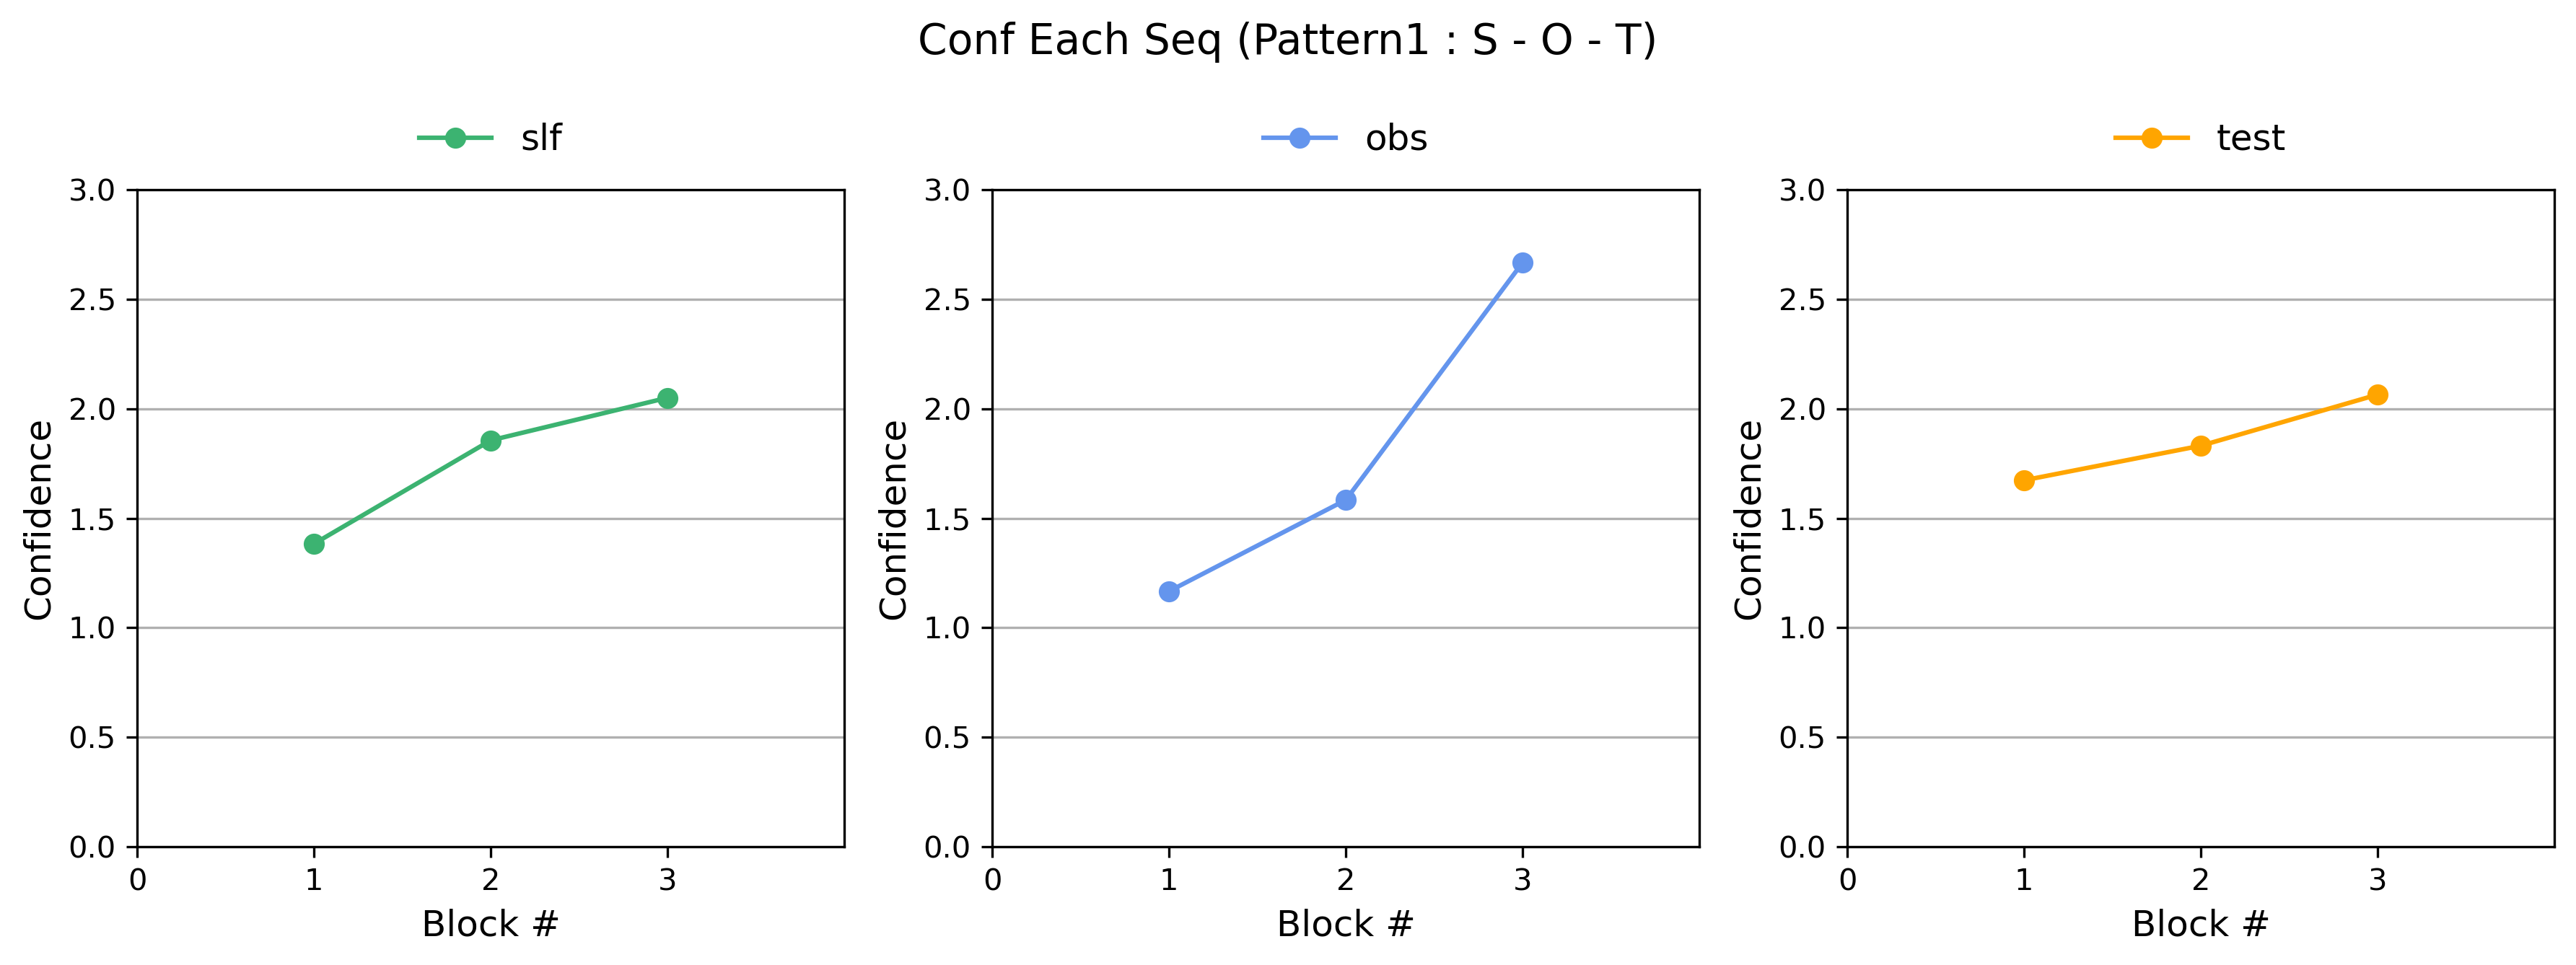

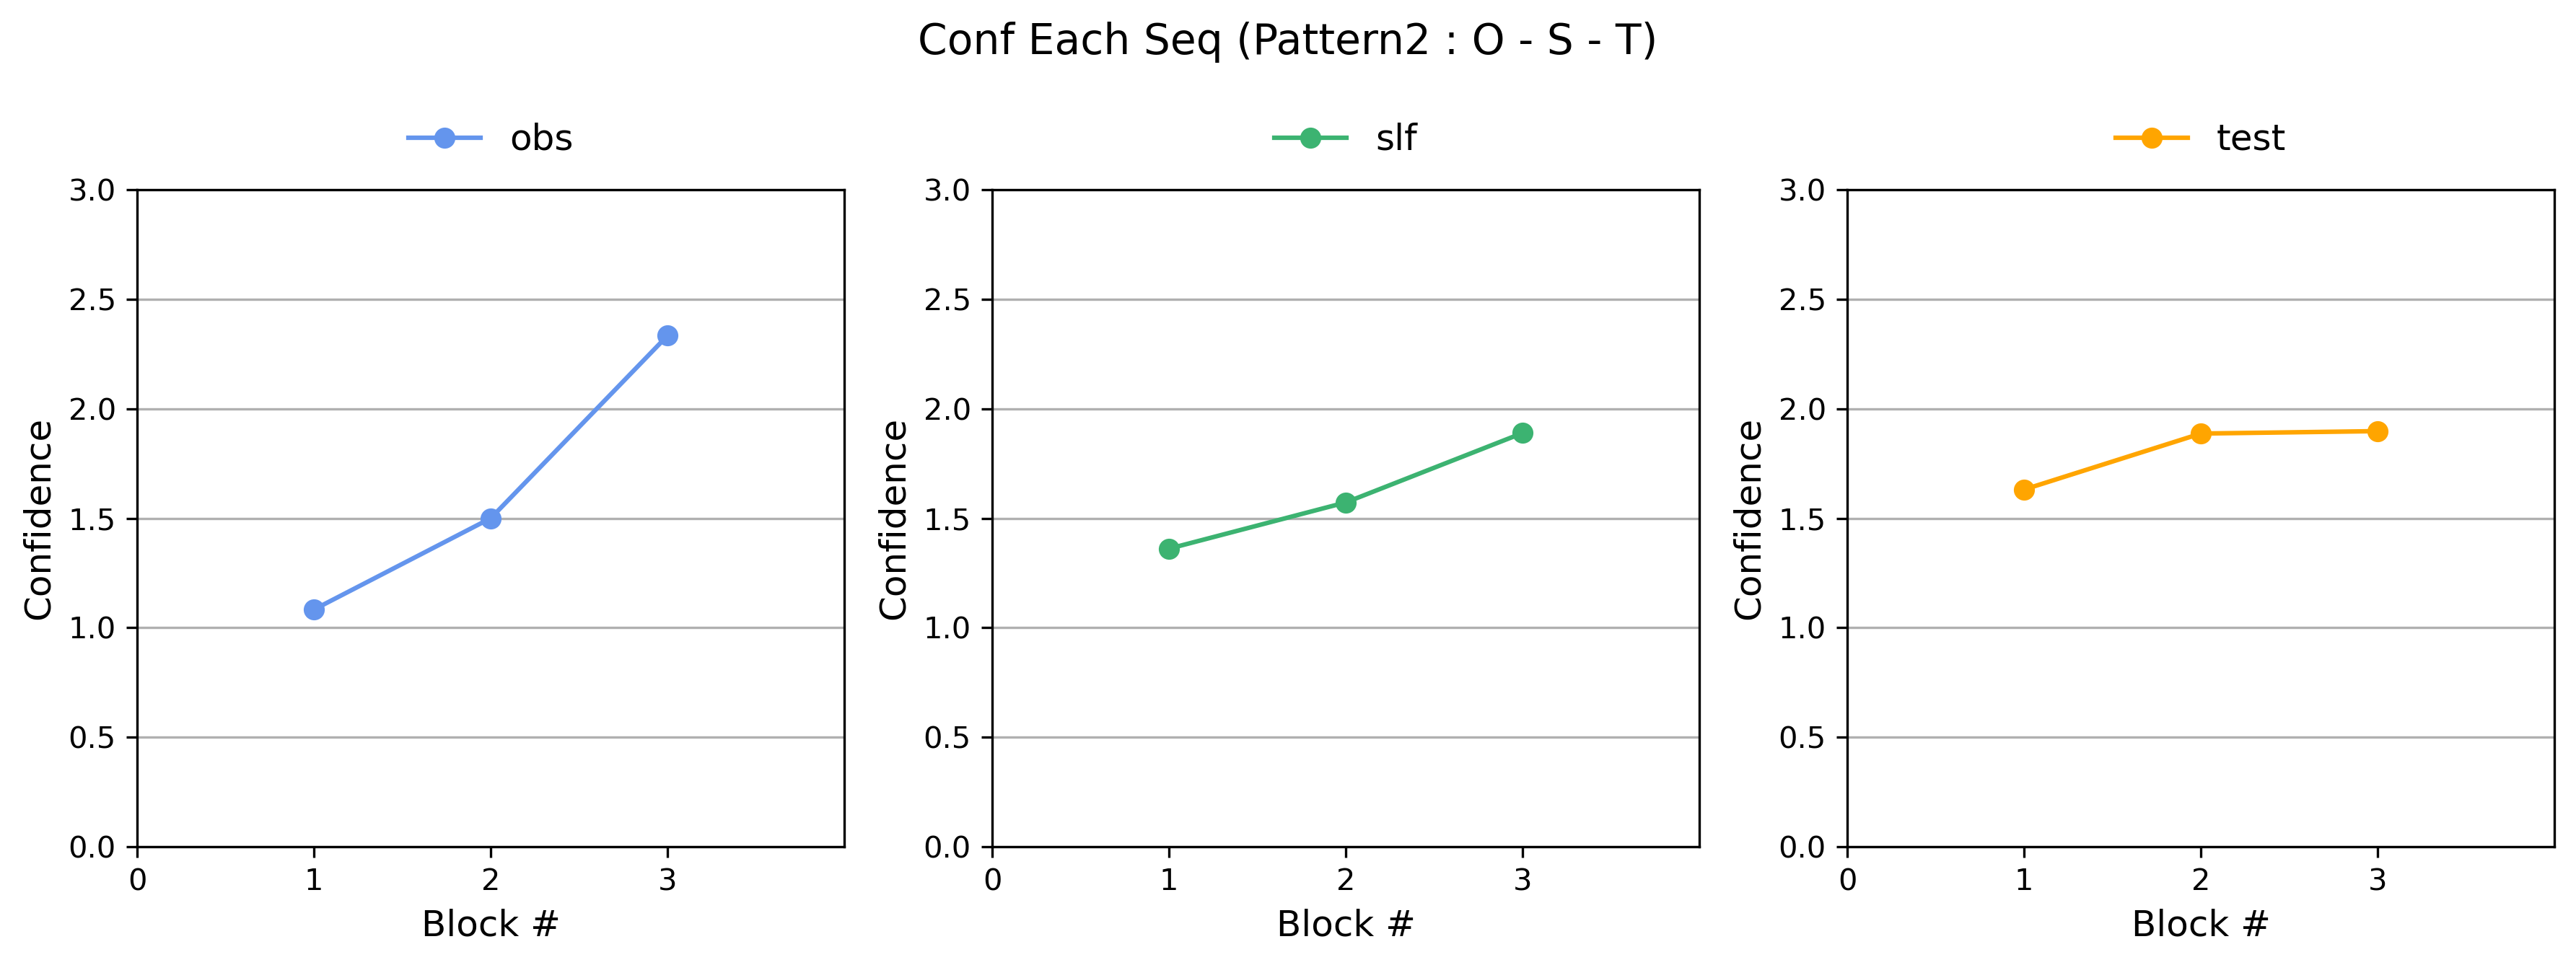

In [13]:
def conf_each_seq(ax, df, seq, width, color, xlim, ylim):
    df = df.select(pl.col('block', 'conf')).groupby('block').mean().sort(by='block')

    ax.plot(df.get_column('block'),
            df.get_column('conf'),
            label=seq,
            # width=width,
            color=color,
            marker='o'
            )
    ax.set_xlim(0, -~xlim)
    ax.set_ylim(0, ylim)
    ax.set_xticks(np.arange(0, -~xlim, step=1))
    ax.set_yticks(np.arange(0, ylim+.1, .5))
    ax.set_xlabel('Block #', fontsize=12)
    ax.set_ylabel('Confidence', fontsize=12)

    ax.grid(axis='y')
    ax.legend(loc='lower center', bbox_to_anchor=(.5,1), ncol=3, frameon=False, fontsize=12)


width = .5

xlim_so = 3
xlim_t = 3
ylim = 3

for pat in range(1, 3):
    s, o = (0, 1) if pat==1 else (1, 0)
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5), dpi=300, tight_layout=True, sharey=False)
    
    conf_each_seq(ax[s], integrated[pat].slf, seq_label[0], width, colors[0], xlim_so, ylim)
    conf_each_seq(ax[o], integrated[pat].obs, seq_label[1], width, colors[1], xlim_so, ylim)
    conf_each_seq(ax[2], integrated[pat].test, seq_label[2], width, colors[2], xlim_t, ylim)
    
    plt.suptitle(f'Conf Each Seq (Pattern{pat} : {pat_label[pat-1]})', fontsize=14)

### Each Pair

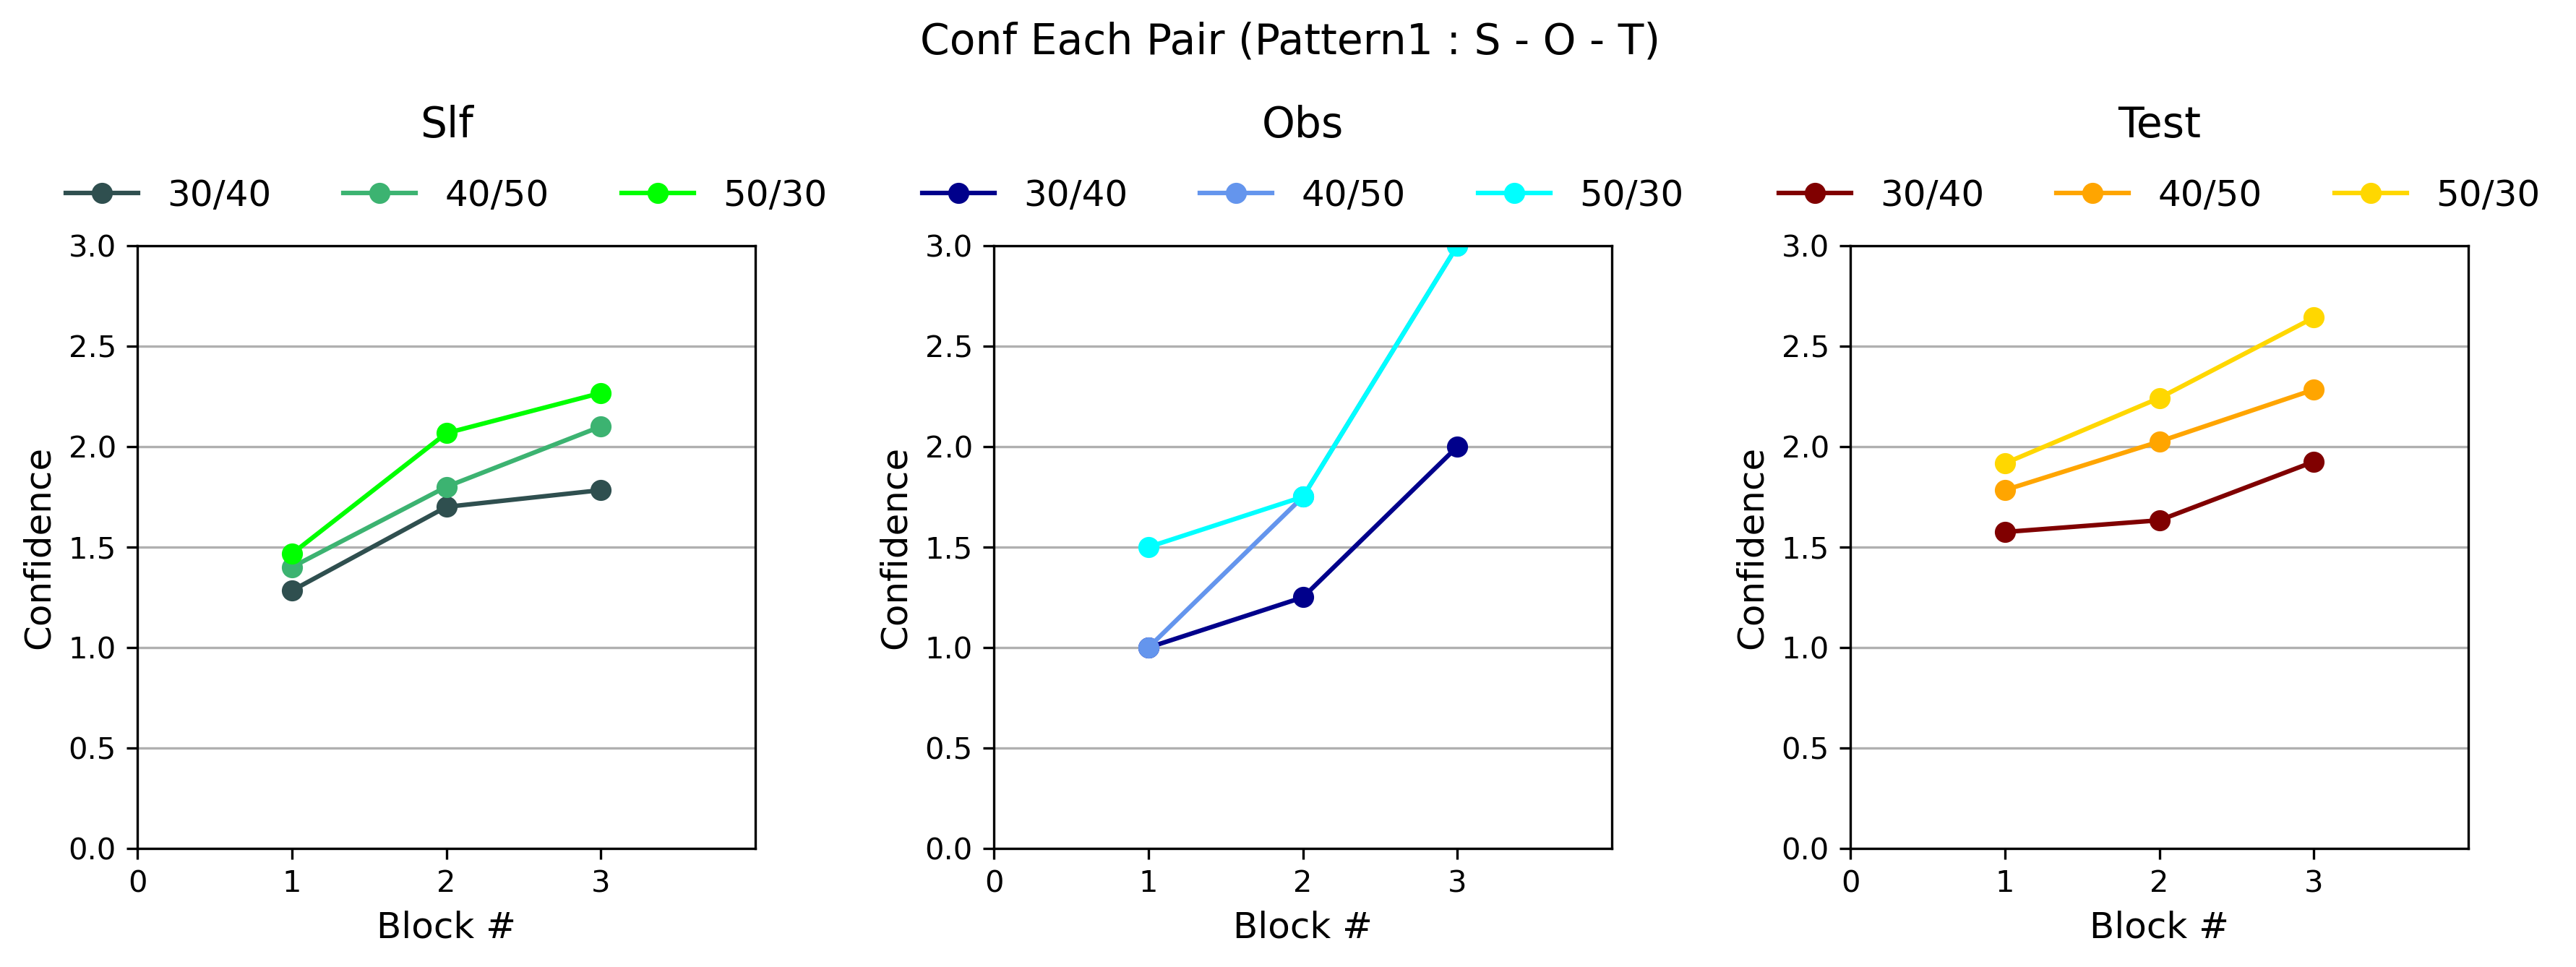

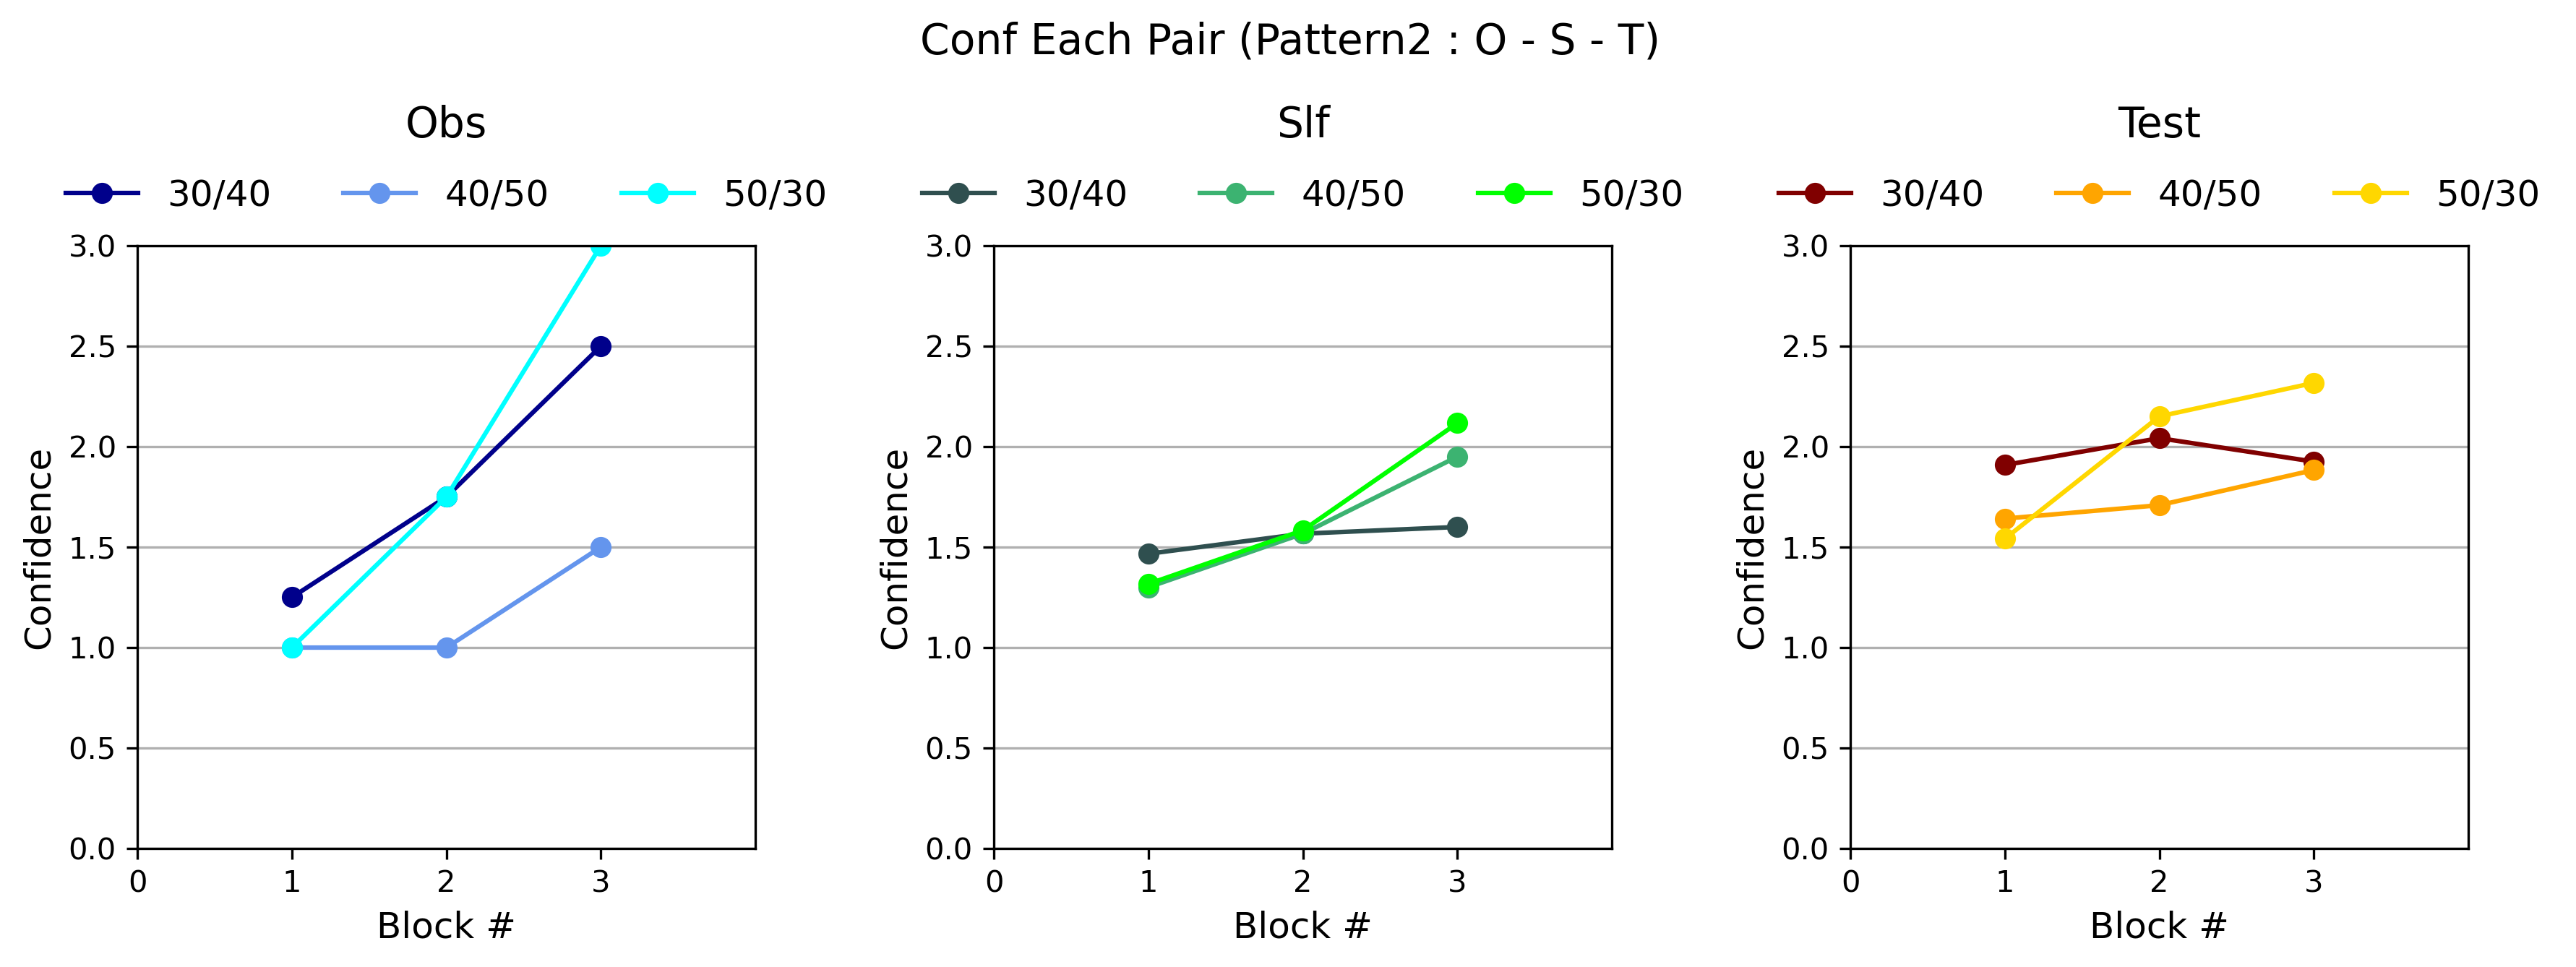

In [14]:
def conf_each_pair(ax, df, seq, pair, width, color, alpha, xlim, ylim):
    df = df.select(pl.col('block', 'loc_pattern', 'conf')).groupby('block', 'loc_pattern')\
        .mean().sort(by='block')

    df1 = df.filter(pl.col('loc_pattern')==1)
    df2 = df.filter(pl.col('loc_pattern')==2)
    df3 = df.filter(pl.col('loc_pattern')==3)

    for i, df_ in enumerate([df1, df2, df3]):
        ax.plot(df_.get_column('block'),
                df_.get_column('conf'),
                label=pair[i],
                # width=width,
                color=color[i],
                # alpha=alpha[i],
                marker='o'
                )

    ax.set_xlim(0, -~xlim)
    ax.set_ylim(0, ylim)
    ax.set_xticks(np.arange(0, -~xlim, step=1))
    ax.set_yticks(np.arange(0, ylim+.1, .5))
    ax.set_xlabel('Block #', fontsize=12)
    ax.set_ylabel('Confidence', fontsize=12)

    ax.set_title(seq, y=1.15, fontsize=14)
    ax.grid(axis='y')
    ax.legend(loc='lower center', bbox_to_anchor=(.5,1), ncol=3, frameon=False, fontsize=12)


# fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), dpi=300, tight_layout=True, sharey=False)

gap = .31
width = .3
alpha = [.5, 1, 1]

xlim_so = 3
xlim_t = 3
ylim = 3

for pat in range(1, 3):
    s, o = (0, 1) if pat==1 else (1, 0)
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5), dpi=300, tight_layout=True, sharey=False)
    
    conf_each_pair(ax[s], integrated[pat].slf, 'Slf', pair_label, width, color_slf, alpha, xlim_so, ylim)
    conf_each_pair(ax[o], integrated[pat].obs, 'Obs', pair_label, width, color_obs, alpha, xlim_so, ylim)
    conf_each_pair(ax[2], integrated[pat].test, 'Test', pair_label, width, color_test, alpha, xlim_t, ylim)
    
    plt.suptitle(f'Conf Each Pair (Pattern{pat} : {pat_label[pat-1]})', fontsize=14)

### Each Condition in Test (SS, OO, SO) 

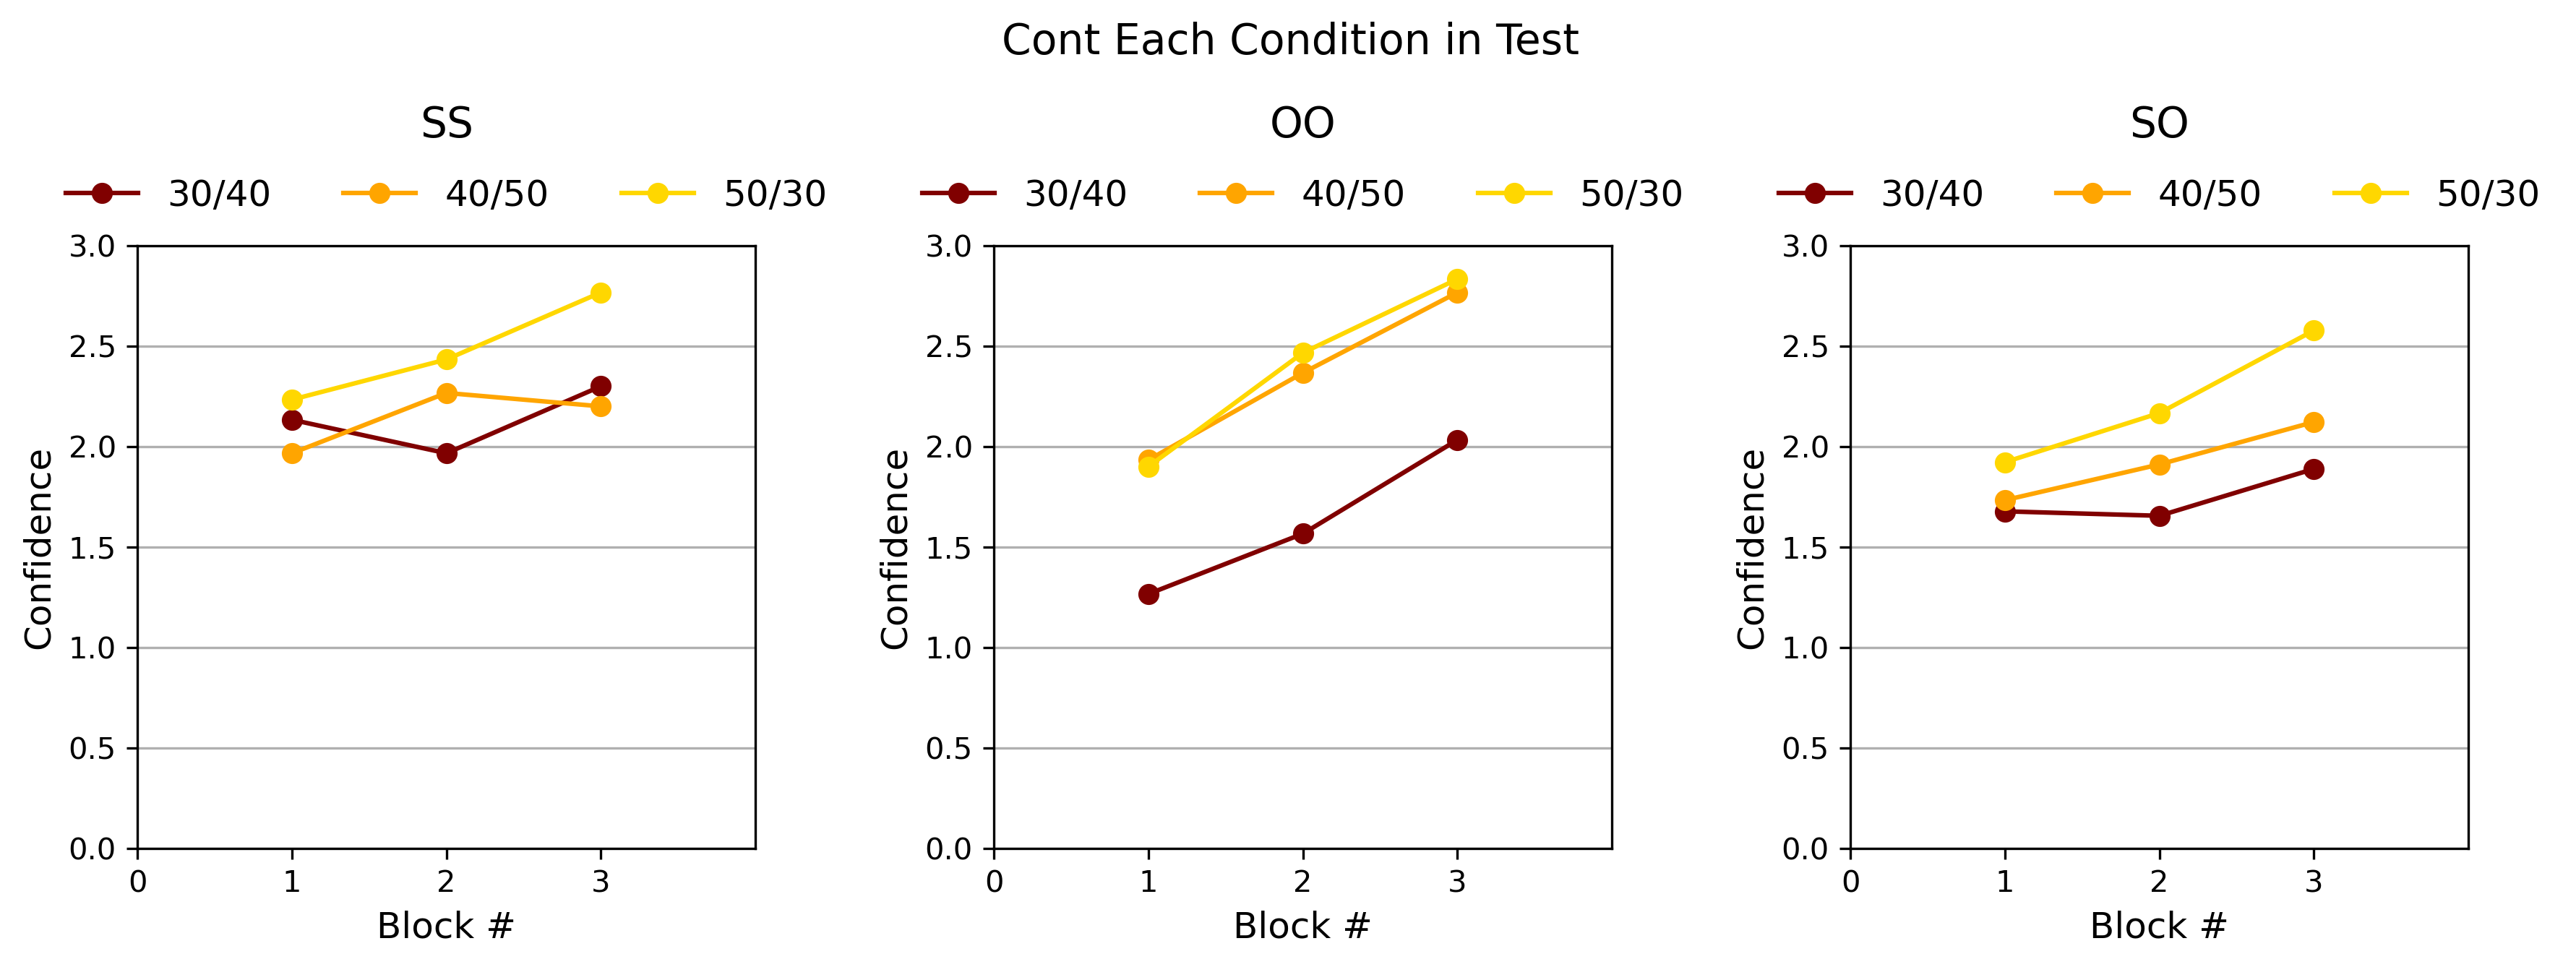

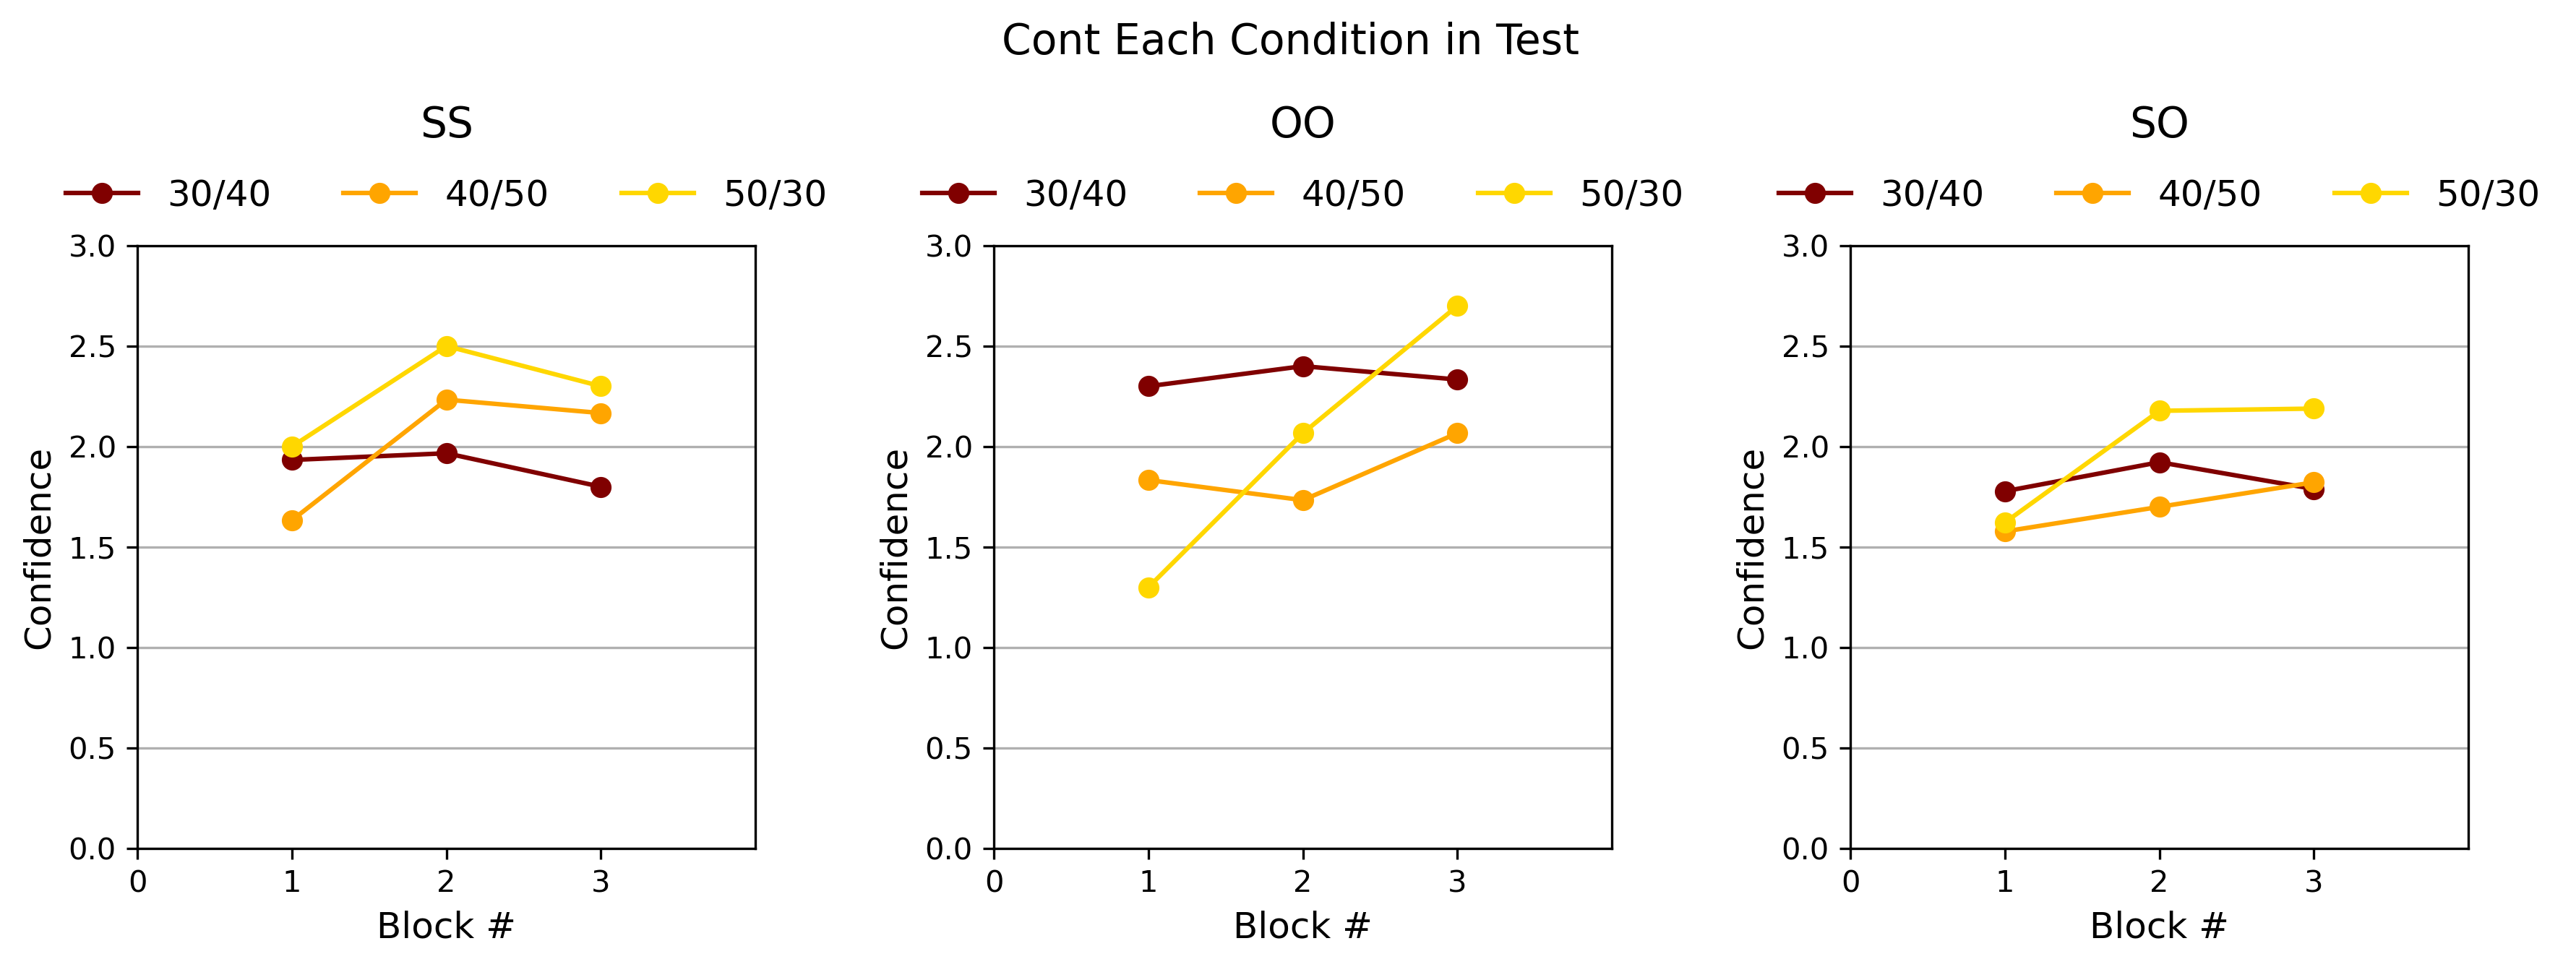

In [15]:
def conf_each_cond(ax, df, cond, pair, width, color, alpha, xlim, ylim):
    df = df.select(pl.col('block', 'loc_pattern', 'conf')).groupby('block', 'loc_pattern')\
        .mean().sort(by='block')

    df1 = df.filter(pl.col('loc_pattern')==1)
    df2 = df.filter(pl.col('loc_pattern')==2)
    df3 = df.filter(pl.col('loc_pattern')==3)

    for i, df_ in enumerate([df1, df2, df3]):
        ax.plot(df_.get_column('block'),
                df_.get_column('conf'),
                label=pair[i],
                # width=width,
                color=color[i],
                # alpha=alpha[i],
                marker='o'
                )

    ax.set_xlim(0, -~xlim)
    ax.set_ylim(0, ylim)
    ax.set_xticks(np.arange(0, -~xlim, step=1))
    ax.set_yticks(np.arange(0, ylim+.1, .5))
    ax.set_xlabel('Block #', fontsize=12)
    ax.set_ylabel('Confidence', fontsize=12)

    ax.set_title(cond, y=1.15, fontsize=14)
    ax.grid(axis='y')
    ax.legend(loc='lower center', bbox_to_anchor=(.5,1), ncol=3, frameon=False, fontsize=12)


gap = .31
width = .3
alpha = [.5, 1, 1]

xlim_so = 3
xlim_t = 3
ylim = 3

for pat in range(1, 3):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5), dpi=300, tight_layout=True, sharey=False)
    
    conf_each_cond(ax[0], integrated[pat].test.filter(pl.col('seq_pattern')=='ss'),
                    'SS', pair_label, width, color_test, alpha, xlim_t, ylim)
    conf_each_cond(ax[1], integrated[pat].test.filter(pl.col('seq_pattern')=='oo'),
                    'OO', pair_label, width, color_test, alpha, xlim_t, ylim)
    conf_each_cond(ax[2], integrated[pat].test.filter(pl.col('seq_pattern')>='so'),
                    'SO', pair_label, width, color_test, alpha, xlim_t, ylim)
    
    plt.suptitle(f'Cont Each Condition in Test', fontsize=14)

LとNLに決着はつかないが、同一視するということにする
温度が低くなればRTが早くなる
confをどうするか
behaviorのエントロピー
testの各ペアで整合性がとれているか（一致：high、不一致：low）
モデルからのuncertaintyとsubjのconfに相関があるか

学習はしていて、confも上昇しており期待するbehaviorではある
confがreliableであるかを確認する
->　fMRIに入れる（15人くらい）（時間を考慮する1スロットか2スロット）
吉田さんが5/9にいらっしゃるので、そのときに計画を話せるようにする

# Accuracy

### Each Sequence

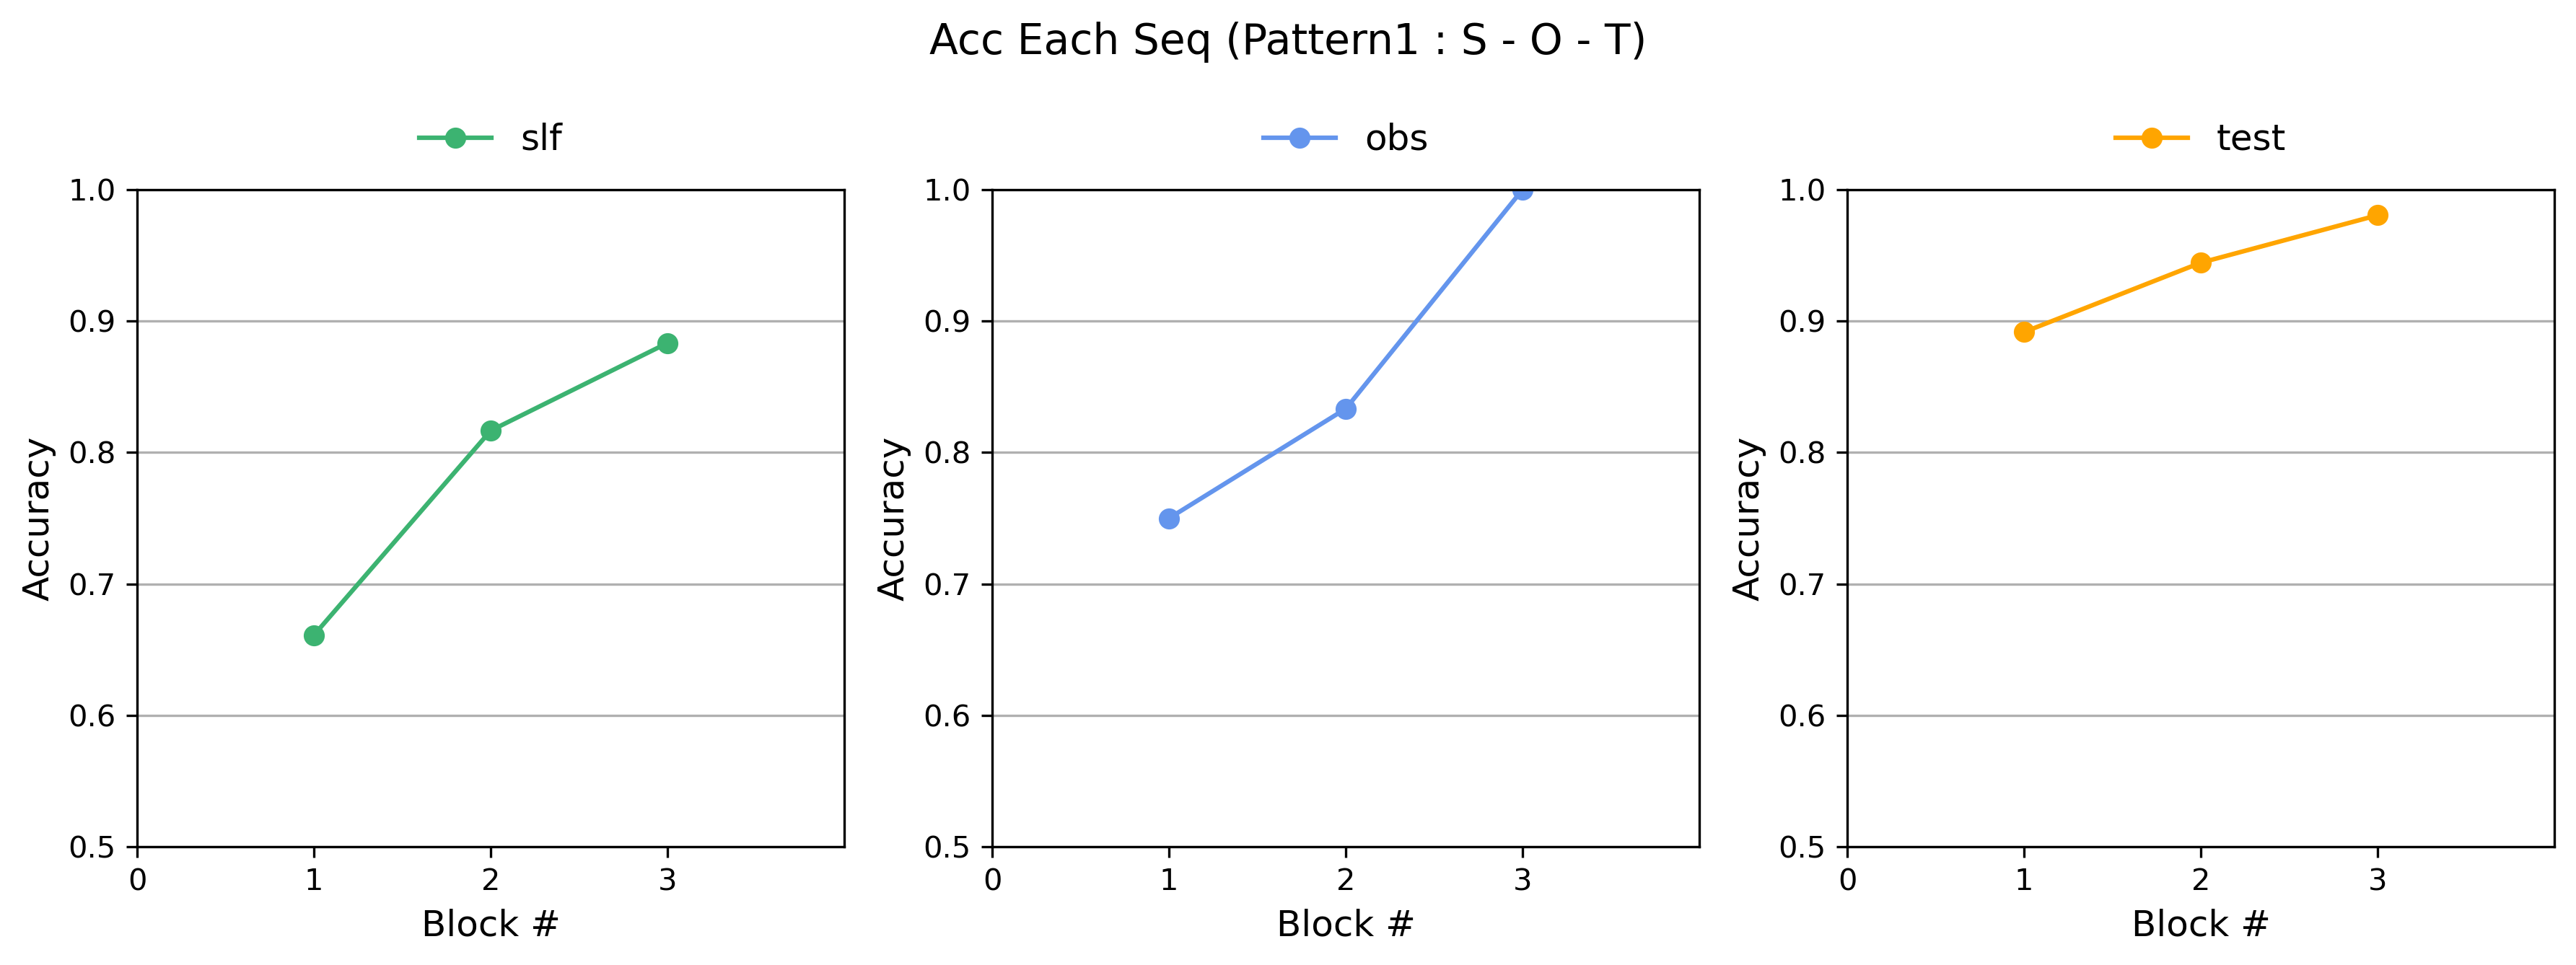

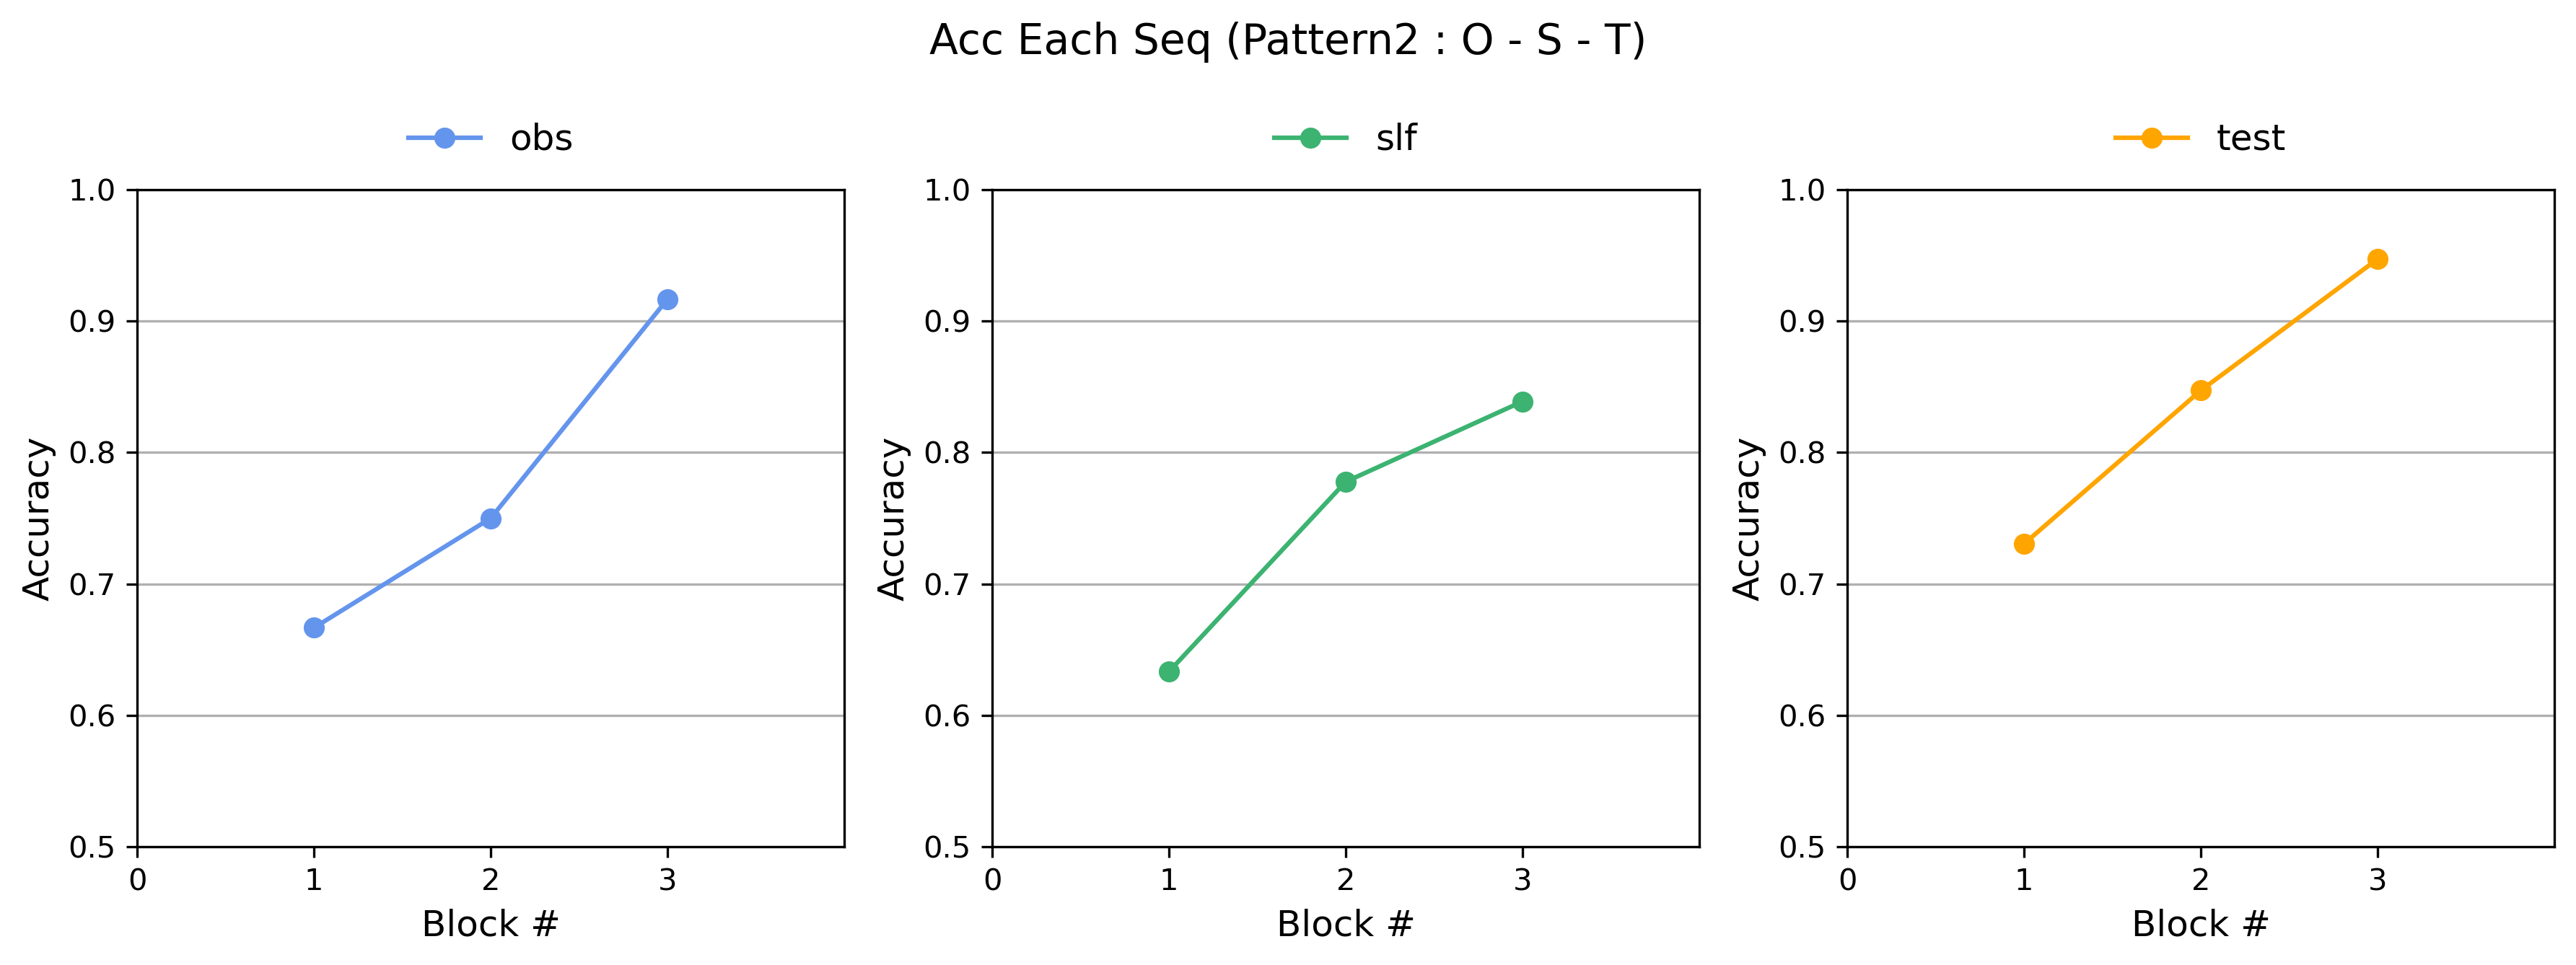

In [16]:
def acc_each_seq(ax, df, seq, width, color, xlim, ylim):
    df = df.filter(pl.col('loc_pattern')<=3).select(pl.col('block', 'pt')).groupby('block').mean().sort(by='block')

    ax.plot(df.get_column('block'),
            df.get_column('pt'),
            label=seq,
            # width=width,
            color=color,
            marker='o'
            )

    ax.set_xlim(0, -~xlim)
    ax.set_ylim(.5, ylim)
    ax.set_xticks(np.arange(0, -~xlim, step=1))
    ax.set_yticks(np.arange(0.5, ylim+.01, .1))
    ax.set_xlabel('Block #', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)

    ax.grid(axis='y')
    ax.legend(loc='lower center', bbox_to_anchor=(.5,1), ncol=3, frameon=False, fontsize=12)


width = .5

xlim_so = 3
xlim_t = 3
ylim = 1

for pat in range(1, 3):
    s, o = (0, 1) if pat==1 else (1, 0)
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5), dpi=300, tight_layout=True, sharey=False)
    
    acc_each_seq(ax[s], integrated[pat].slf, seq_label[0], width, colors[0], xlim_so, ylim)
    acc_each_seq(ax[o], integrated[pat].obs, seq_label[1], width, colors[1], xlim_so, ylim)
    acc_each_seq(ax[2], integrated[pat].test, seq_label[2], width, colors[2], xlim_t, ylim)
    
    plt.suptitle(f'Acc Each Seq (Pattern{pat} : {pat_label[pat-1]})', fontsize=14)

### Each Pair

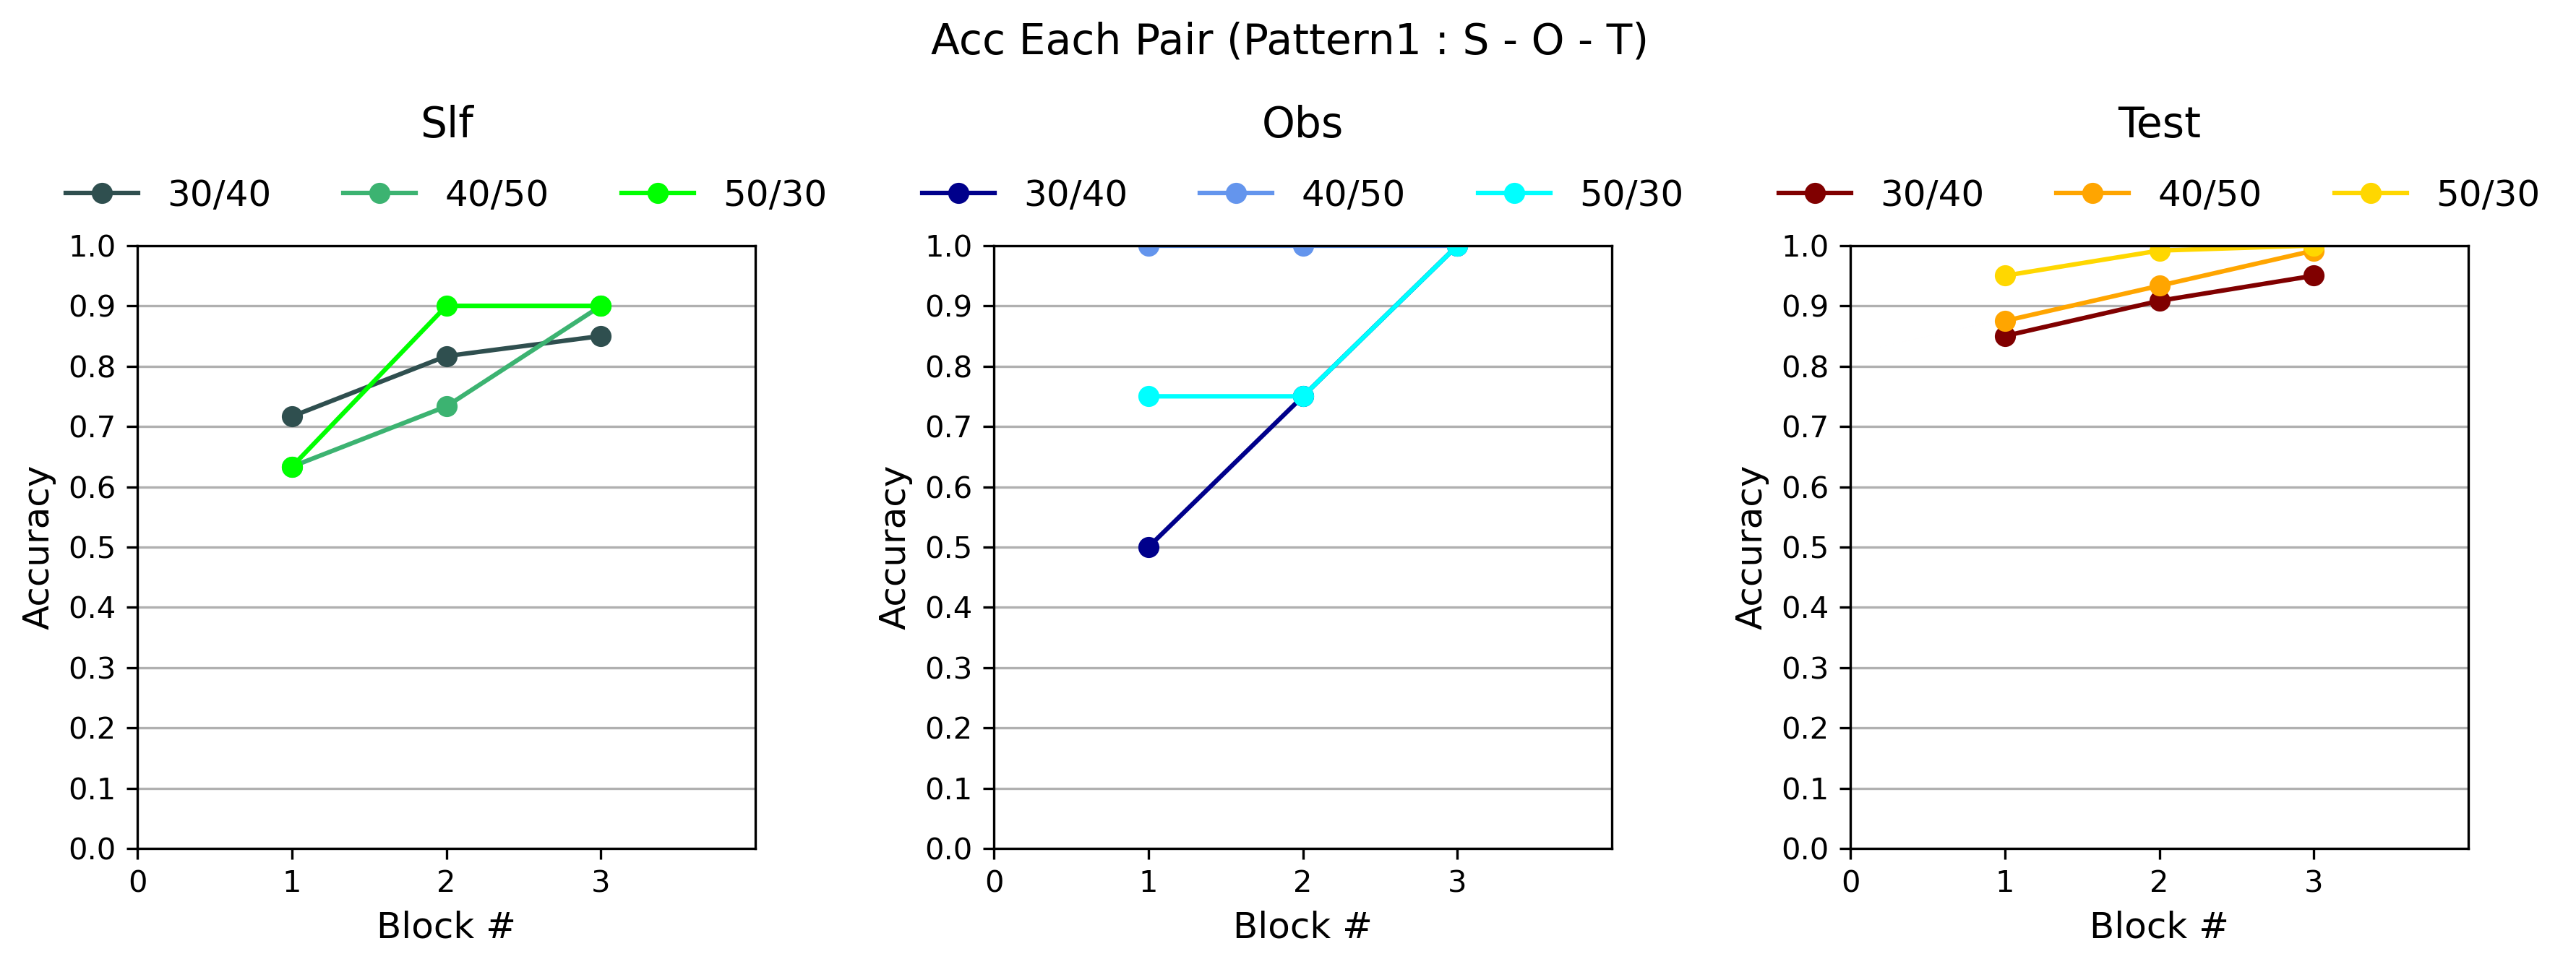

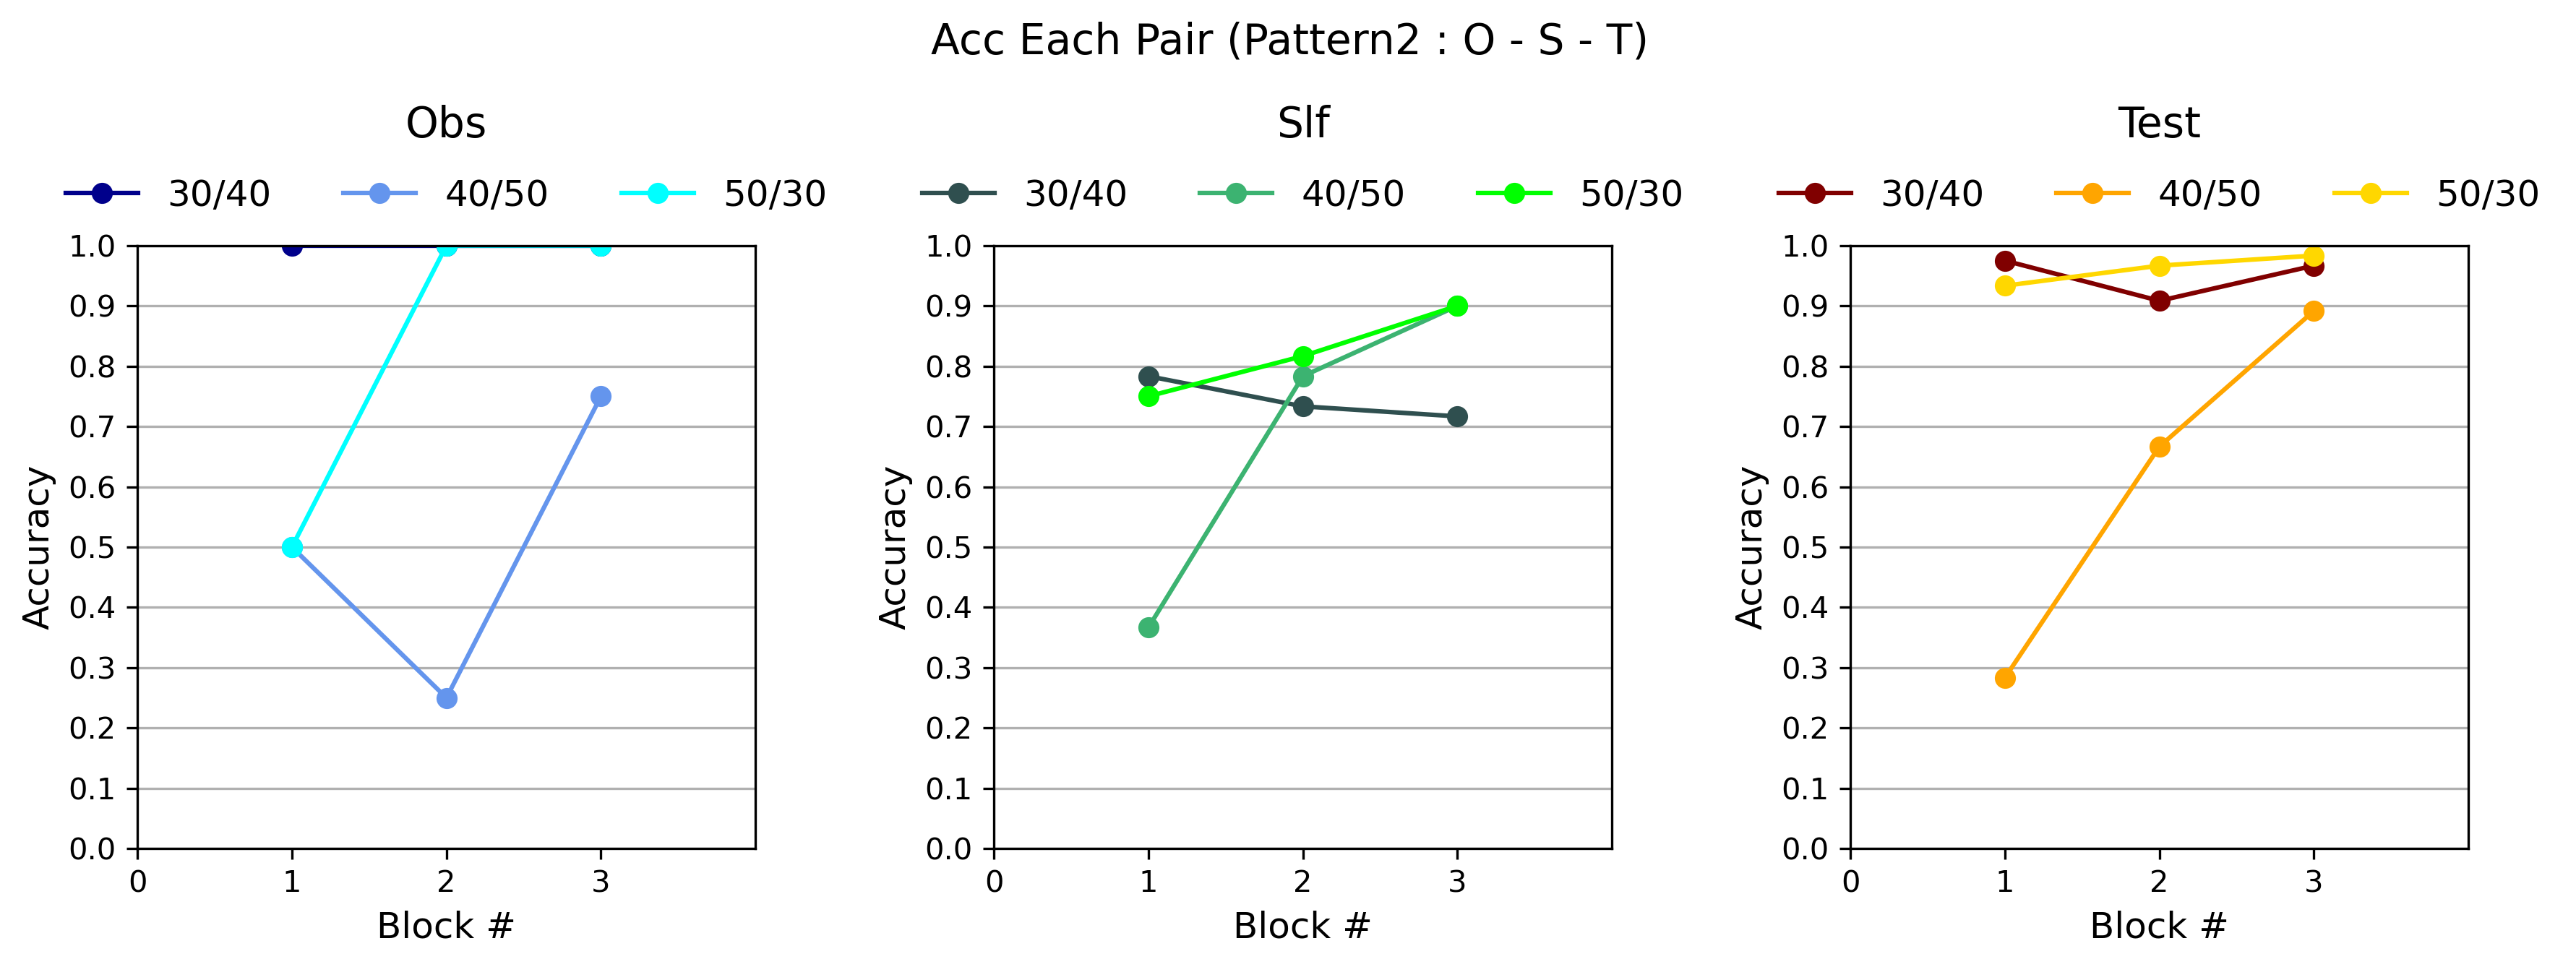

In [25]:
def acc_each_pair(ax, df, seq, pair, width, color, alpha, xlim, ylim):
    df = df.filter(pl.col('loc_pattern')<=3).select(pl.col('block', 'loc_pattern', 'pt'))\
        .groupby('block', 'loc_pattern').mean().sort(by='block')

    df1 = df.filter(pl.col('loc_pattern')==1)
    df2 = df.filter(pl.col('loc_pattern')==2)
    df3 = df.filter(pl.col('loc_pattern')==3)

    for i, df_ in enumerate([df1, df2, df3]):
        ax.plot(df_.get_column('block'),
                df_.get_column('pt'),
                label=pair[i],
                # width=width,
                color=color[i],
                # alpha=alpha[i],
                marker='o'
                )

    ax.set_xlim(0, -~xlim)
    ax.set_ylim(0, ylim)
    ax.set_xticks(np.arange(0, -~xlim, step=1))
    ax.set_yticks(np.arange(0, ylim+.01, .1))
    ax.set_xlabel('Block #', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)

    ax.set_title(seq, y=1.15, fontsize=14)
    ax.grid(axis='y')
    ax.legend(loc='lower center', bbox_to_anchor=(.5,1), ncol=3, frameon=False, fontsize=12)


gap = .31
width = .3
alpha = [.5, 1, 1]

xlim_so = 3
xlim_t = 3
ylim = 1

for pat in range(1, 3):
    s, o = (0, 1) if pat==1 else (1, 0)
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5), dpi=300, tight_layout=True, sharey=False)

    acc_each_pair(ax[s], integrated[pat].slf, 'Slf', pair_label, width, color_slf, alpha, xlim_so, ylim)
    acc_each_pair(ax[o], integrated[pat].obs, 'Obs', pair_label, width, color_obs, alpha, xlim_so, ylim)
    acc_each_pair(ax[2], integrated[pat].test, 'Test', pair_label, width, color_test, alpha, xlim_t, ylim)

    plt.suptitle(f'Acc Each Pair (Pattern{pat} : {pat_label[pat-1]})', fontsize=14)

### Each Condition in Test (SS, OO, SO) 

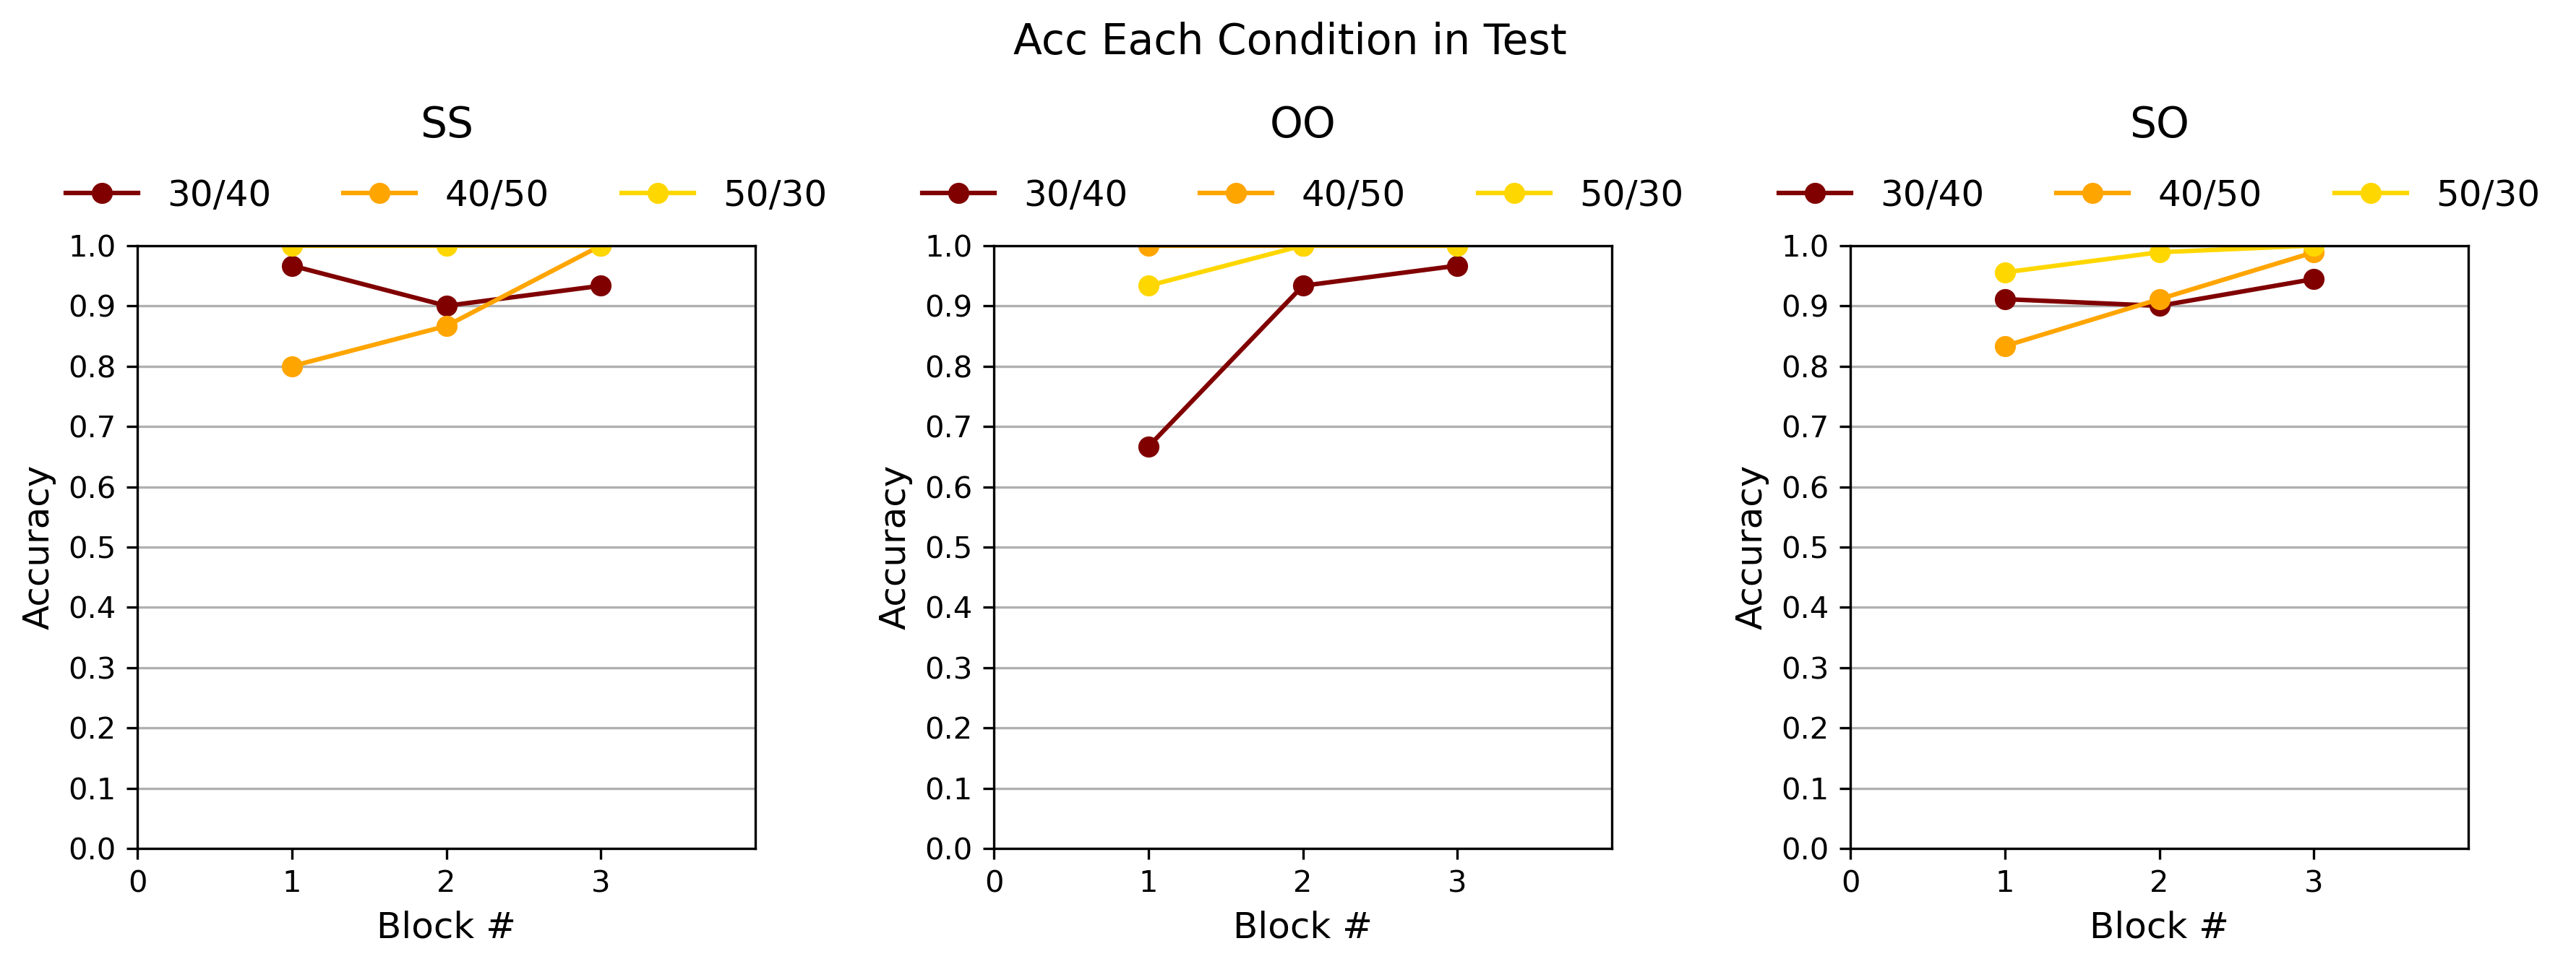

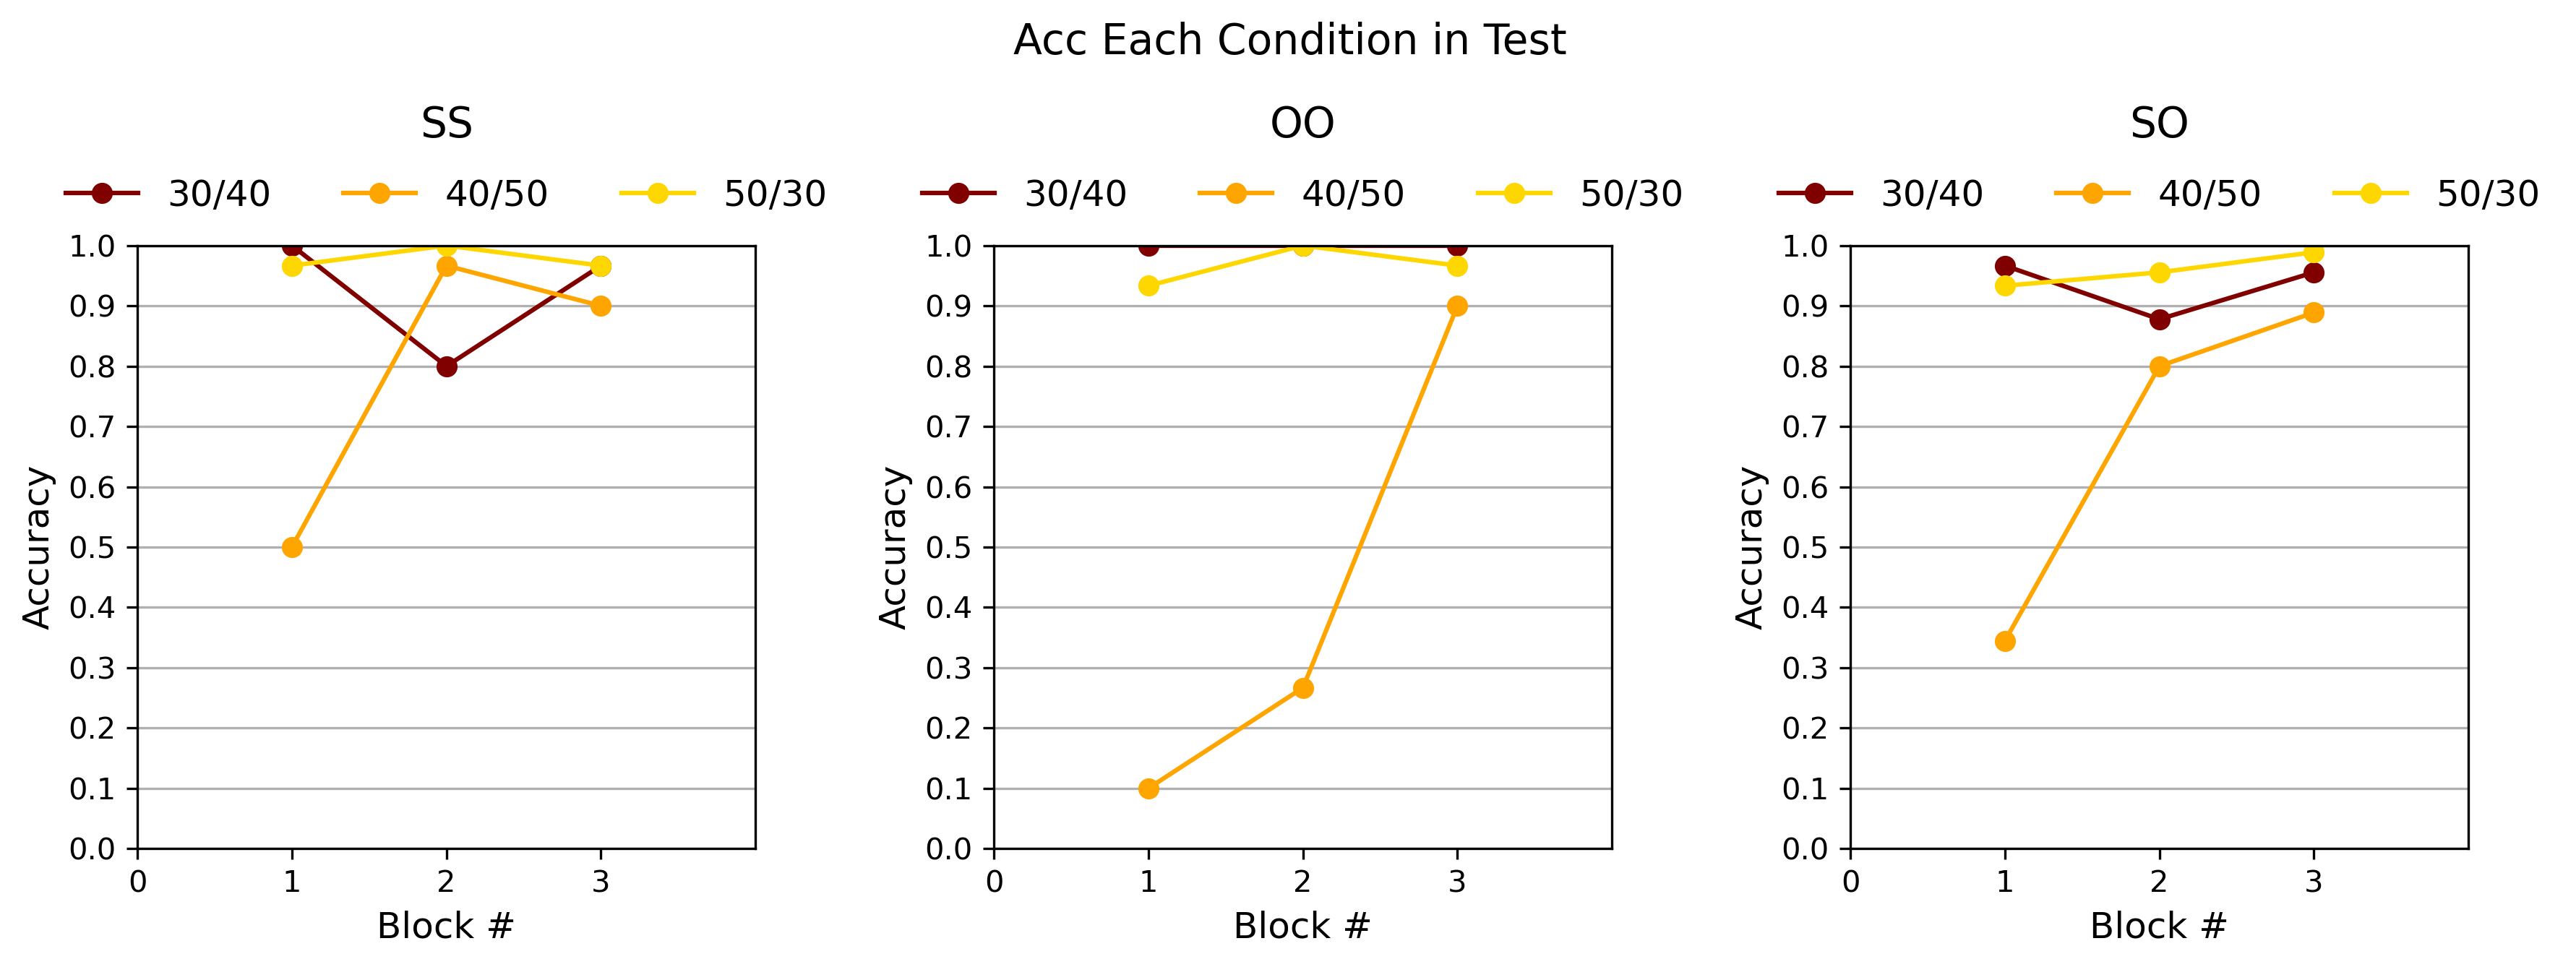

In [18]:
def acc_each_cond(ax, df, cond, pair, width, color, alpha, xlim, ylim):
    df = df.filter(pl.col('loc_pattern')<=3).select(pl.col('block', 'loc_pattern', 'pt'))\
        .groupby('block', 'loc_pattern').mean().sort(by='block')
    # df = df.select(pl.col('block', 'loc_pattern', 'conf')).groupby('block', 'loc_pattern')\
    #     .mean().sort(by='block')

    df1 = df.filter(pl.col('loc_pattern')==1)
    df2 = df.filter(pl.col('loc_pattern')==2)
    df3 = df.filter(pl.col('loc_pattern')==3)

    for i, df_ in enumerate([df1, df2, df3]):
        ax.plot(df_.get_column('block'),
                df_.get_column('pt'),
                label=pair[i],
                # width=width,
                color=color[i],
                # alpha=alpha[i],
                marker='o'
                )

    ax.set_xlim(0, -~xlim)
    ax.set_ylim(0, ylim)
    ax.set_xticks(np.arange(0, -~xlim, step=1))
    ax.set_yticks(np.arange(0, ylim+.01, .1))
    ax.set_xlabel('Block #', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)

    ax.set_title(cond, y=1.15, fontsize=14)
    ax.grid(axis='y')
    ax.legend(loc='lower center', bbox_to_anchor=(.5,1), ncol=3, frameon=False, fontsize=12)


gap = .31
width = .3
alpha = [.5, 1, 1]

xlim_so = 3
xlim_t = 3
ylim = 1

for pat in range(1, 3):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5), dpi=300, tight_layout=True, sharey=False)
    
    acc_each_cond(ax[0], integrated[pat].test.filter(pl.col('seq_pattern')=='ss'),
                    'SS', pair_label, width, color_test, alpha, xlim_t, ylim)
    acc_each_cond(ax[1], integrated[pat].test.filter(pl.col('seq_pattern')=='oo'),
                    'OO', pair_label, width, color_test, alpha, xlim_t, ylim)
    acc_each_cond(ax[2], integrated[pat].test.filter(pl.col('seq_pattern')>='so'),
                    'SO', pair_label, width, color_test, alpha, xlim_t, ylim)
    
    plt.suptitle(f'Acc Each Condition in Test', fontsize=14)

### Consistency of Confidence in Test

We are currently investigating whether the confidence level in the test sequence is reliable.

Specifically, when an image pair that was selected with high confidence in the past is presented again, we examine whether the same image is selected with the same high confidence as before.

In [28]:
df_ = integrated[1].test
df_

shape: (1_350, 28)
┌─────────┬────────┬───────┬─────────────┬───┬─────────┬──────┬───────┬────────────┐
│ game_No ┆ seq_No ┆ block ┆ seq_pattern ┆ … ┆ subj_No ┆ type ┆ group ┆ idx_choice │
│ ---     ┆ ---    ┆ ---   ┆ ---         ┆   ┆ ---     ┆ ---  ┆ ---   ┆ ---        │
│ i64     ┆ i64    ┆ i64   ┆ str         ┆   ┆ i32     ┆ str  ┆ i32   ┆ i32        │
╞═════════╪════════╪═══════╪═════════════╪═══╪═════════╪══════╪═══════╪════════════╡
│ 25      ┆ 1      ┆ 1     ┆ ss          ┆ … ┆ 1       ┆ test ┆ 1     ┆ 3          │
│ 26      ┆ 2      ┆ 1     ┆ oo          ┆ … ┆ 1       ┆ test ┆ 1     ┆ 2          │
│ 27      ┆ 3      ┆ 1     ┆ so          ┆ … ┆ 1       ┆ test ┆ 1     ┆ 3          │
│ 28      ┆ 4      ┆ 1     ┆ so          ┆ … ┆ 1       ┆ test ┆ 1     ┆ 3          │
│ …       ┆ …      ┆ …     ┆ …           ┆ … ┆ …       ┆ …    ┆ …     ┆ …          │
│ 159     ┆ 87     ┆ 3     ┆ ss          ┆ … ┆ 15      ┆ test ┆ 1     ┆ 2          │
│ 160     ┆ 88     ┆ 3     ┆ so          ┆ … ┆ 15      ┆ test ┆ 1     ┆ 1          │
│ 161     ┆ 89     ┆ 3     ┆ so          ┆ … ┆ 15      ┆ test ┆ 1     ┆ 3          │
│ 162     ┆ 90     ┆ 3     ┆ so          ┆ … ┆ 15      ┆ test ┆ 1     ┆ 3          │
└─────────┴────────┴───────┴─────────────┴───┴─────────┴──────┴───────┴────────────┘

In [41]:
pl.Config.set_tbl_rows(8)
df_ = integrated[1].test.filter((pl.col('seq_pattern')=='ss') & (pl.col('loc_pattern')==1)).sort(by='subj_No')
print(df_.filter(pl.col('block')==1).select('subj_No', 'block', 'conf').is_duplicated().sum())
df_.select('subj_No', 'block', 'conf')

22


shape: (90, 3)
┌─────────┬───────┬──────┐
│ subj_No ┆ block ┆ conf │
│ ---     ┆ ---   ┆ ---  │
│ i32     ┆ i64   ┆ i64  │
╞═════════╪═══════╪══════╡
│ 1       ┆ 1     ┆ 3    │
│ 1       ┆ 1     ┆ 3    │
│ 1       ┆ 2     ┆ 3    │
│ 1       ┆ 2     ┆ 3    │
│ …       ┆ …     ┆ …    │
│ 15      ┆ 2     ┆ 2    │
│ 15      ┆ 2     ┆ 2    │
│ 15      ┆ 3     ┆ 2    │
│ 15      ┆ 3     ┆ 2    │
└─────────┴───────┴──────┘

In [23]:
df_ = integrated[1].test.filter((pl.col('seq_pattern')=='ss') & (pl.col('loc_pattern')==1))
df_ = df_.with_colmuns(pl.col('subj_No'))
df_ = df_.filter(pl.col('loc_pattern')<=3).select(pl.col('subj_No', 'block', 'loc_pattern', 'conf'))\
        .groupby('subj_No', 'block', 'loc_pattern').agg(
                pl.when(pl.col('conf')=='correct', 1).otherwise(0).alias('consistency')
                )

df_

shape: (9, 3)
┌───────┬─────────────┬──────────┐
│ block ┆ loc_pattern ┆ conf     │
│ ---   ┆ ---         ┆ ---      │
│ i64   ┆ i64         ┆ f64      │
╞═══════╪═════════════╪══════════╡
│ 1     ┆ 2           ┆ 1.966667 │
│ 3     ┆ 3           ┆ 2.766667 │
│ 1     ┆ 1           ┆ 2.133333 │
│ 3     ┆ 2           ┆ 2.2      │
│ …     ┆ …           ┆ …        │
│ 2     ┆ 2           ┆ 2.266667 │
│ 2     ┆ 1           ┆ 1.966667 │
│ 2     ┆ 3           ┆ 2.433333 │
│ 3     ┆ 1           ┆ 2.3      │
└───────┴─────────────┴──────────┘

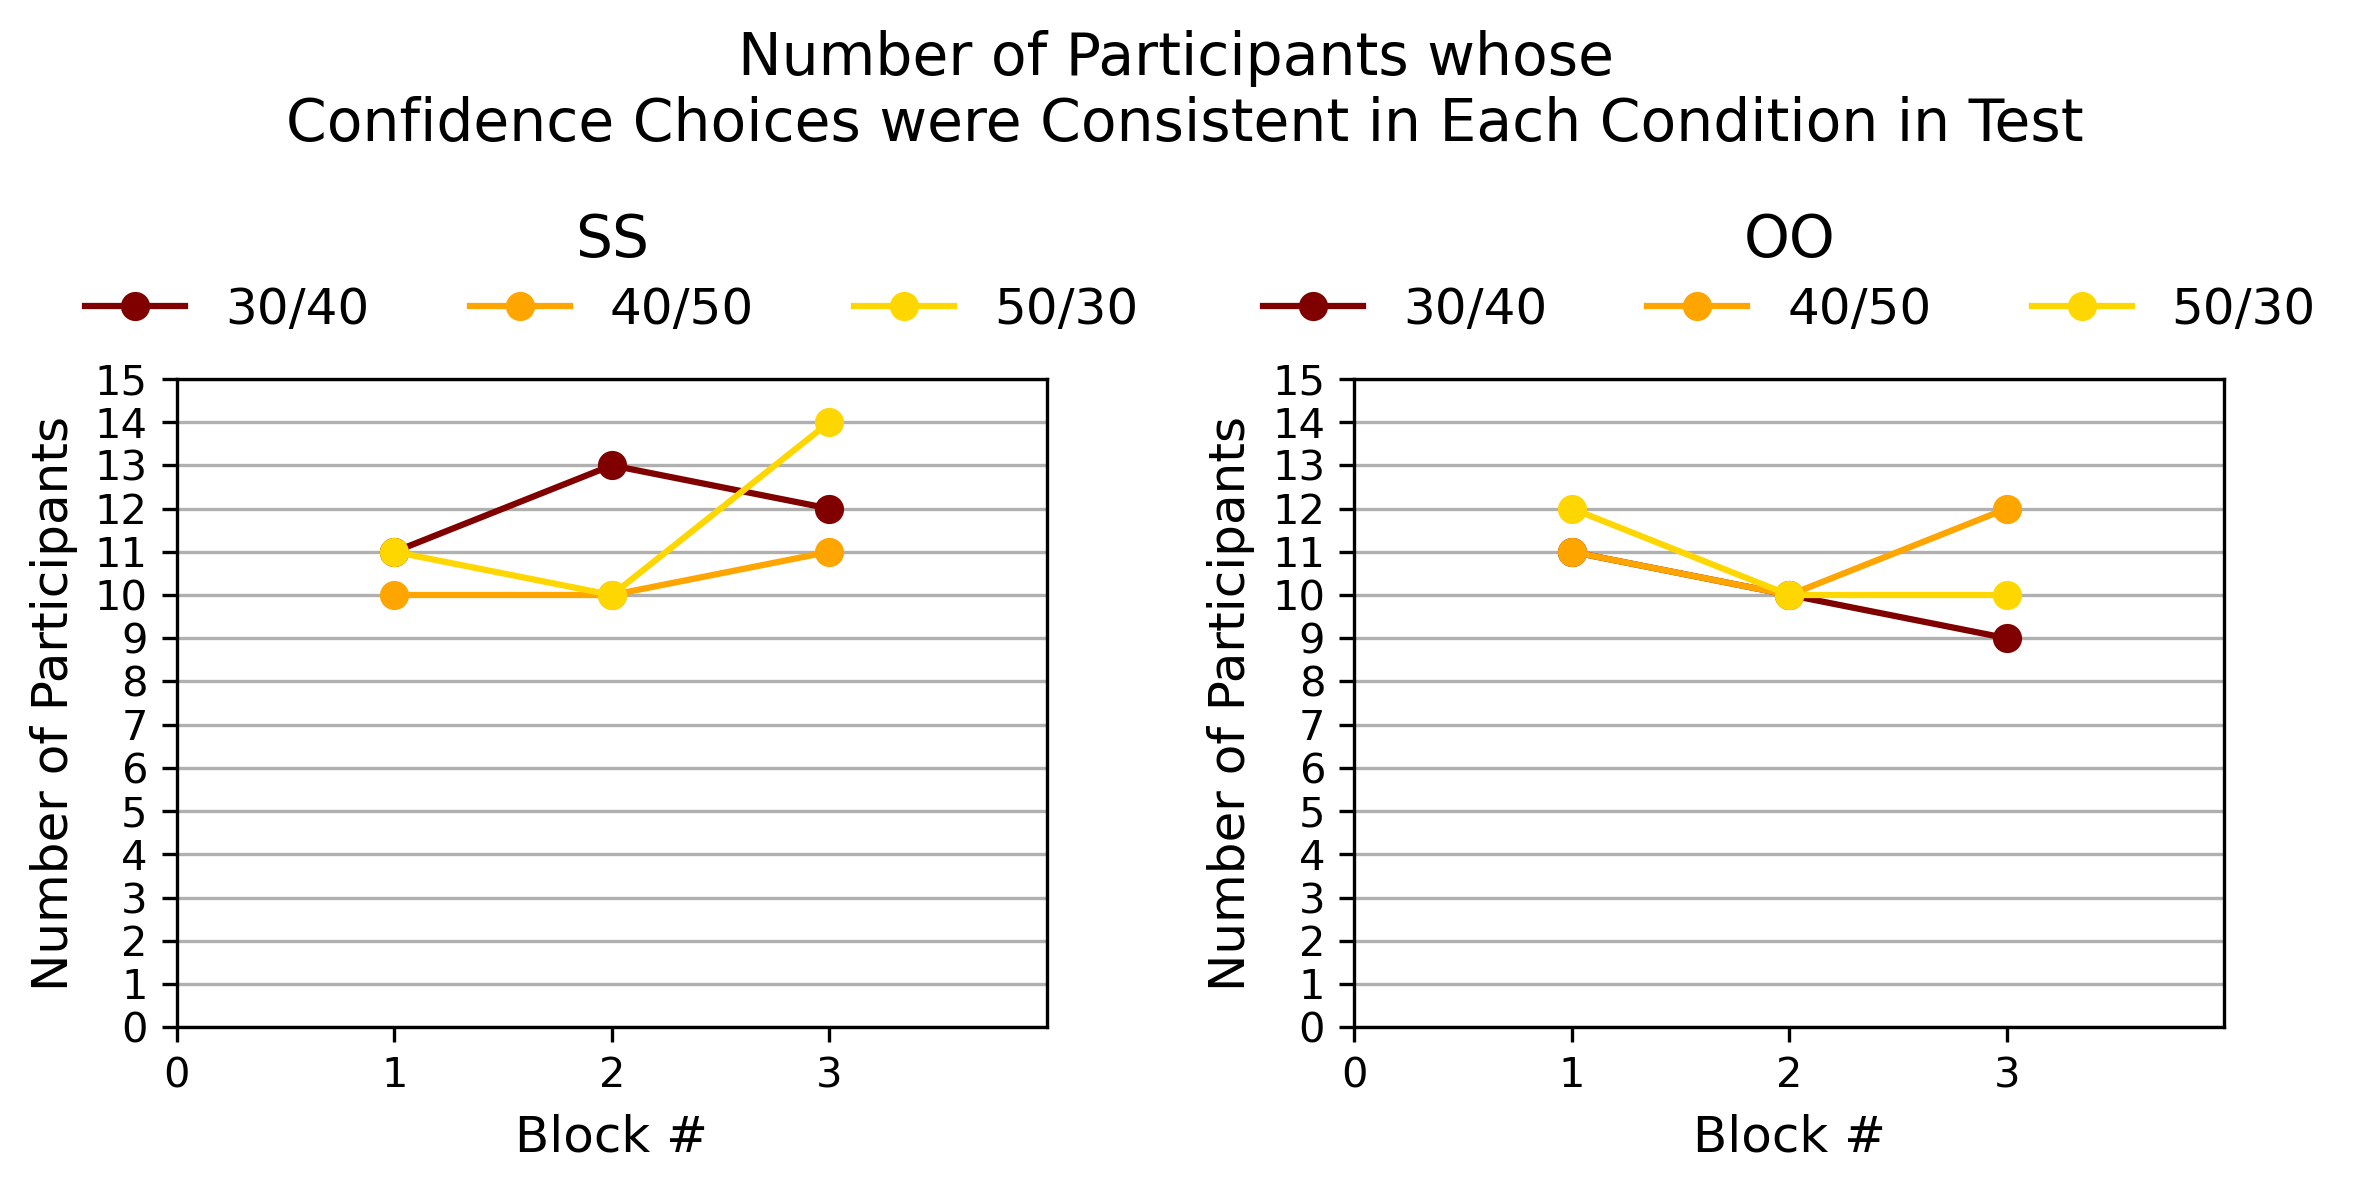

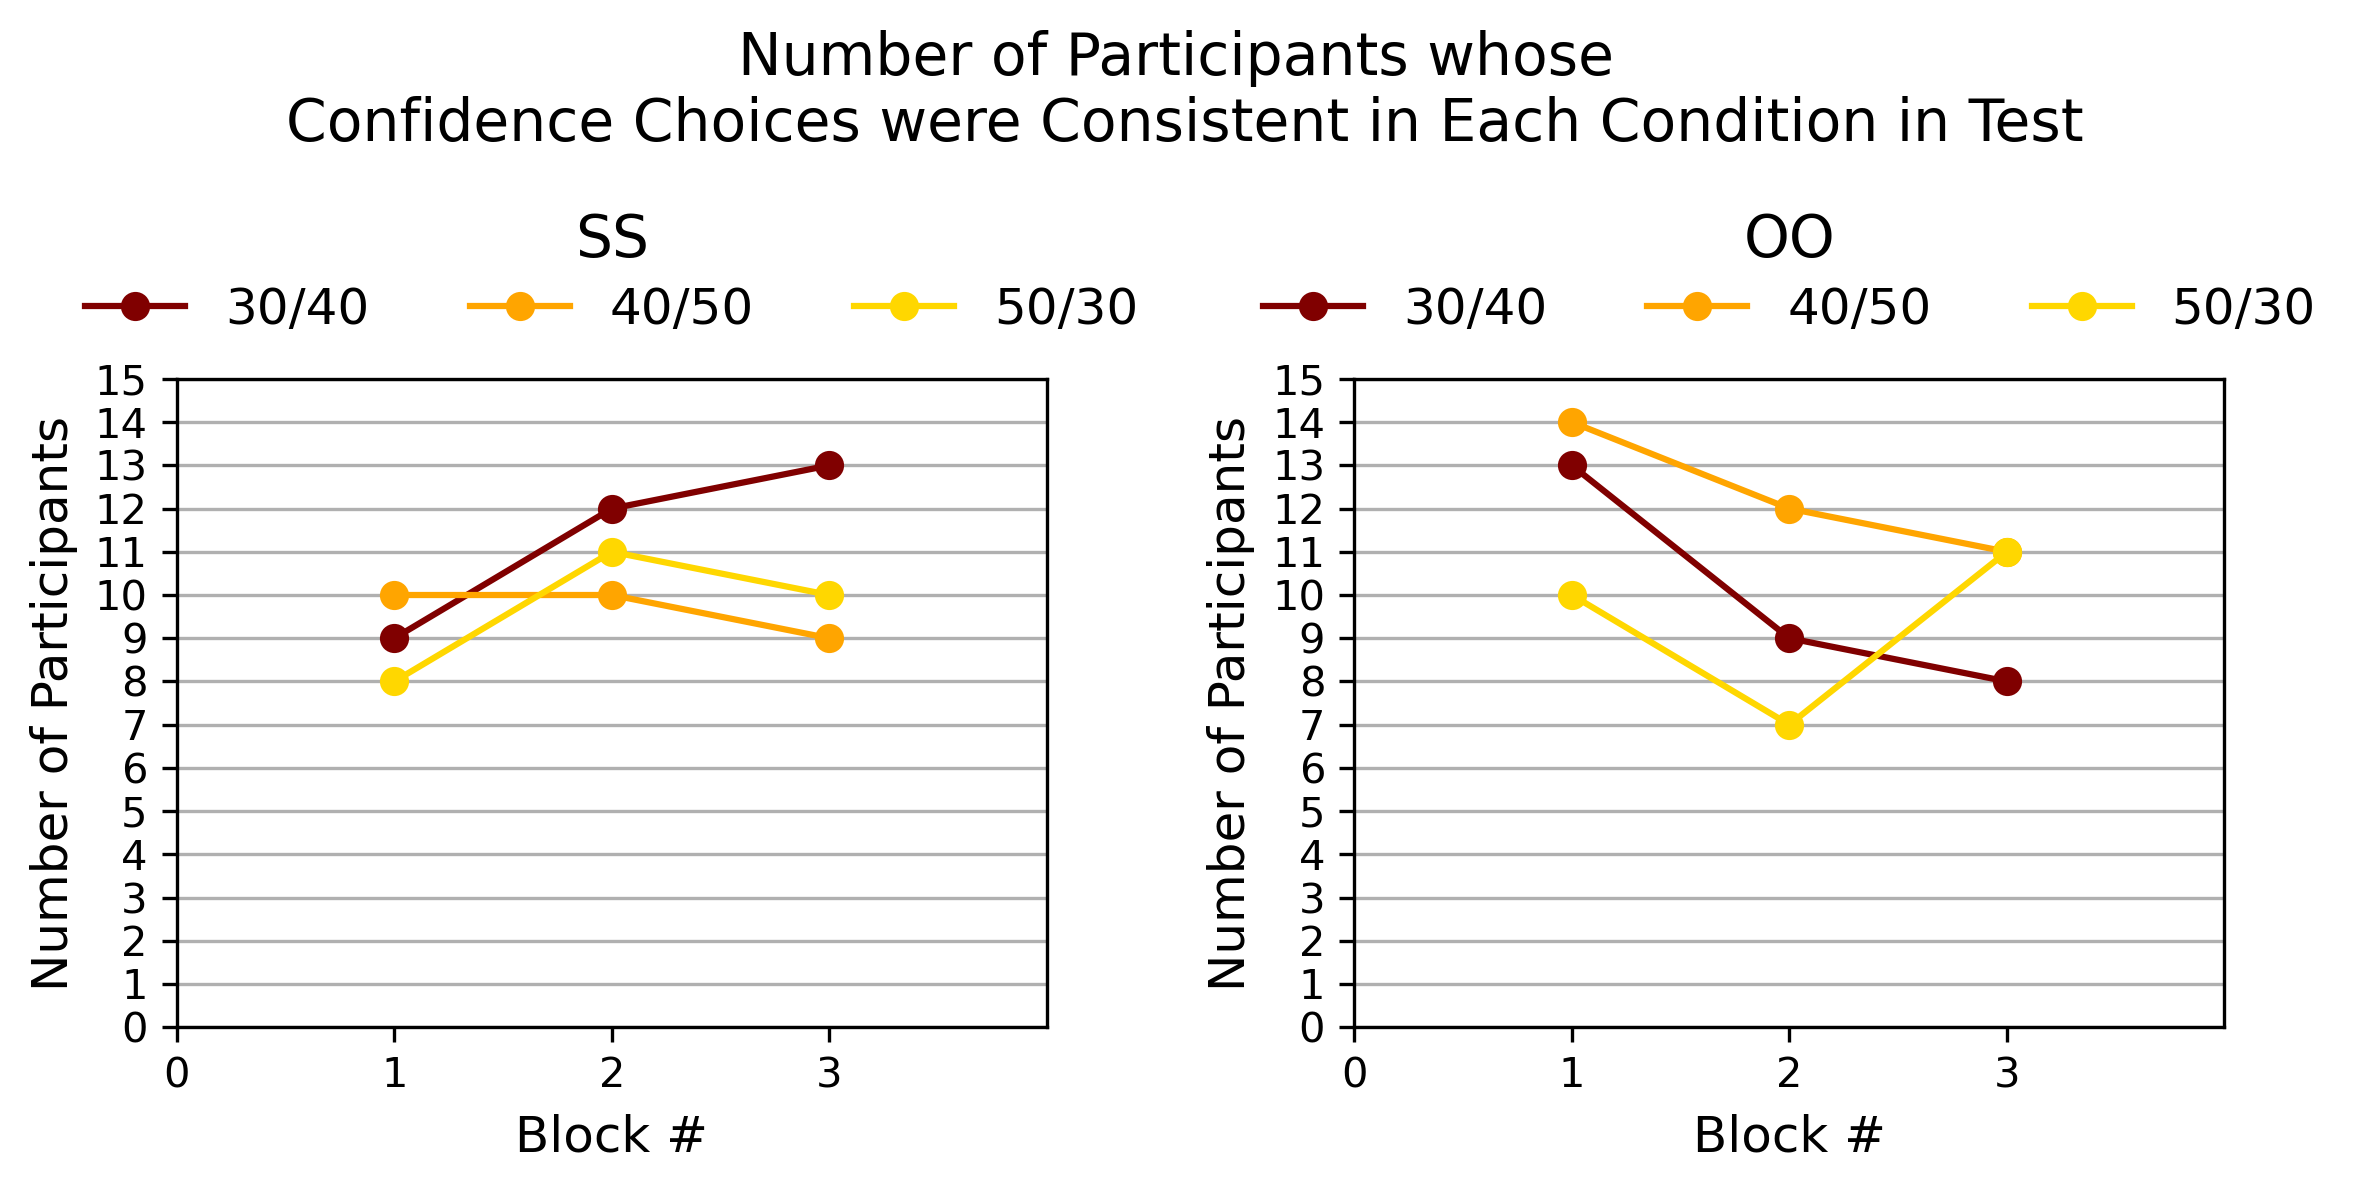

In [54]:
def concistency_each_individual(ax, df, cond, pair, width, color, alpha, xlim, ylim):
    # df = df.filter(pl.col('loc_pattern')<=3).select(pl.col('block', 'loc_pattern', 'conf'))\
    #     .groupby('block', 'loc_pattern').mean().sort(by='block')

    df1 = df.filter(pl.col('loc_pattern')==1)
    df2 = df.filter(pl.col('loc_pattern')==2)
    df3 = df.filter(pl.col('loc_pattern')==3)
    duplicate = [0] * 3
    
    for i, df_ in enumerate([df1, df2, df3]):
        for block in range(1, 4):
            duplicate[block-1] = df_.filter(pl.col('block')==block).select('subj_No', 'block', 'conf')\
                                    .is_duplicated().sum() / 2

        ax.plot([1, 2 ,3],
                duplicate,
                label=pair[i],
                # width=width,
                color=color[i],
                # alpha=alpha[black-1],
                marker='o'
                )

    ax.set_xlim(0, -~xlim)
    ax.set_ylim(0, ylim)
    ax.set_xticks(np.arange(0, -~xlim, step=1))
    ax.set_yticks(np.arange(0, ylim+.1, 1))
    ax.set_xlabel('Block #', fontsize=12)
    ax.set_ylabel('Number of Participants', fontsize=12)

    ax.set_title(cond, y=1.15, fontsize=14)
    ax.grid(axis='y')
    ax.legend(loc='lower center', bbox_to_anchor=(.5,1), ncol=3, frameon=False, fontsize=12)


gap = .31
width = .3
alpha = [.5, 1, 1]

xlim_so = 3
xlim_t = 3
ylim = 15

for pat in range(1, 3):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=300, tight_layout=True, sharey=False)
    
    concistency_each_individual(ax[0], integrated[pat].test.filter(pl.col('seq_pattern')=='ss'),
                    'SS', pair_label, width, color_test, alpha, xlim_t, ylim)
    concistency_each_individual(ax[1], integrated[pat].test.filter(pl.col('seq_pattern')=='oo'),
                    'OO', pair_label, width, color_test, alpha, xlim_t, ylim)
    # concistency_each_individual(ax[2], integrated[pat].test.filter(pl.col('seq_pattern')>='so'),
    #                 'SO', pair_label, width, color_test, alpha, xlim_t, ylim)

    plt.suptitle(f'Number of Participants whose \nConfidence Choices were Consistent in Each Condition in Test', fontsize=14)

# Statistical Test

In [ ]:
def mannwhitneyu_test_group(t1, t2):
    p =[0 for _ in range(9)]

    for bi in range(3):
        arr_ss1 = t1[(t1['seq_pattern']==1) & (t1['block']==bi+1)].groupby('subj').mean()['pt']
        arr_ss2 = t2[(t2['seq_pattern']==1) & (t2['block']==bi+1)].groupby('subj').mean()['pt']

        arr_oo1 = t1[(t1['seq_pattern']==2) & (t1['block']==bi+1)].groupby('subj').mean()['pt']
        arr_oo2 = t2[(t2['seq_pattern']==2) & (t2['block']==bi+1)].groupby('subj').mean()['pt']

        arr_so1 = t1[(t1['seq_pattern']>=3) & (t1['loc_pattern']<=3) & (t1['block']==bi+1)].groupby('subj').mean()['pt']
        arr_so2 = t2[(t2['seq_pattern']>=3) & (t2['loc_pattern']<=3) & (t2['block']==bi+1)].groupby('subj').mean()['pt']

        p[bi]   = stats.mannwhitneyu(arr_ss1, arr_ss2, alternative='two-sided').pvalue
        p[bi+3] = stats.mannwhitneyu(arr_oo1, arr_oo2, alternative='two-sided').pvalue
        p[bi+6] = stats.mannwhitneyu(arr_so1, arr_so2, alternative='two-sided').pvalue

    return p


def binomial_test_chance(t):
    p =[0 for _ in range(9)]
    block = [1, 2, 3]

    for bi in block:
        arr_ss = t[(t['seq_pattern']==1) & (t['block']==bi)]['pt']
        corr_ss = np.count_nonzero(arr_ss == 1)

        arr_oo = t[(t['seq_pattern']==2) & (t['block']==bi)]['pt']
        corr_oo = np.count_nonzero(arr_oo == 1)

        arr_so = t[(t['seq_pattern']>=3) & (t['loc_pattern']<=3) & (t['block']==bi)]['pt']
        corr_so = np.count_nonzero(arr_so == 1)

        p[bi-1] = stats.binomtest(corr_ss, len(arr_ss), 0.5, 'greater').pvalue
        p[bi+2] = stats.binomtest(corr_oo, len(arr_oo), 0.5, 'greater').pvalue
        p[bi+5] = stats.binomtest(corr_so, len(arr_so), 0.5, 'greater').pvalue

    return p


def wilcoxon_test_diff(t):
    p =[0 for _ in range(6)]

    for bi in range(2):
        arr_ss1 = t[(t['seq_pattern']==1) & (t['block']==bi+1)].groupby('subj').mean()['pt']
        arr_ss2 = t[(t['seq_pattern']==1) & (t['block']==bi+2)].groupby('subj').mean()['pt']

        arr_oo1 = t[(t['seq_pattern']==2) & (t['block']==bi+1)].groupby('subj').mean()['pt']
        arr_oo2 = t[(t['seq_pattern']==2) & (t['block']==bi+2)].groupby('subj').mean()['pt']

        arr_so1 = t[(t['seq_pattern']>=3) & (t['loc_pattern']<=3) & (t['block']==bi+1)].groupby('subj').mean()['pt']
        arr_so2 = t[(t['seq_pattern']>=3) & (t['loc_pattern']<=3) & (t['block']==bi+2)].groupby('subj').mean()['pt']

        p[bi]   = stats.wilcoxon(arr_ss1, arr_ss2, zero_method='zsplit', alternative='less').pvalue
        p[bi+2] = stats.wilcoxon(arr_oo1, arr_oo2, zero_method='zsplit', alternative='less').pvalue
        p[bi+4] = stats.wilcoxon(arr_so1, arr_so2, zero_method='zsplit', alternative='less').pvalue

    return p


def wilcoxon_test_diff2(t):
    p =[0 for _ in range(3)]

    arr_ss1 = t[(t['seq_pattern']==1) & (t['block']==1)].groupby('subj').mean()['pt']
    arr_ss2 = t[(t['seq_pattern']==1) & (t['block']==3)].groupby('subj').mean()['pt']

    arr_oo1 = t[(t['seq_pattern']==2) & (t['block']==1)].groupby('subj').mean()['pt']
    arr_oo2 = t[(t['seq_pattern']==2) & (t['block']==3)].groupby('subj').mean()['pt']

    arr_so1 = t[(t['seq_pattern']>=3) & (t['loc_pattern']<=3) & (t['block']==1)].groupby('subj').mean()['pt']
    arr_so2 = t[(t['seq_pattern']>=3) & (t['loc_pattern']<=3) & (t['block']==3)].groupby('subj').mean()['pt']

    p[0]   = stats.wilcoxon(arr_ss1, arr_ss2, zero_method='zsplit', alternative='less').pvalue
    p[1] = stats.wilcoxon(arr_oo1, arr_oo2, zero_method='zsplit', alternative='less').pvalue
    p[2] = stats.wilcoxon(arr_so1, arr_so2, zero_method='zsplit', alternative='less').pvalue

    return p


def wilcoxon_test_pat(t1, t2):
    p =[0 for _ in range(9)]

    for bi in range(3):
        arr_ss1 = t1[(t1['seq_pattern']==1) & (t1['block']==bi+1)].groupby('subj').mean()['pt']
        arr_ss2 = t2[(t2['seq_pattern']==1) & (t2['block']==bi+1)].groupby('subj').mean()['pt']

        arr_oo1 = t1[(t1['seq_pattern']==2) & (t1['block']==bi+1)].groupby('subj').mean()['pt']
        arr_oo2 = t2[(t2['seq_pattern']==2) & (t2['block']==bi+1)].groupby('subj').mean()['pt']

        arr_so1 = t1[(t1['seq_pattern']>=3) & (t1['loc_pattern']<=3) & (t1['block']==bi+1)].groupby('subj').mean()['pt']
        arr_so2 = t2[(t2['seq_pattern']>=3) & (t2['loc_pattern']<=3) & (t2['block']==bi+1)].groupby('subj').mean()['pt']

        p[bi]   = stats.wilcoxon(arr_ss1, arr_ss2, alternative='greater').pvalue
        p[bi+3] = stats.wilcoxon(arr_oo1, arr_oo2, alternative='greater').pvalue
        p[bi+6] = stats.wilcoxon(arr_so1, arr_so2, alternative='greater').pvalue

    return p

In [ ]:
print('\n','between groups : U two-sided')
for i in range(2):
    pvalue = mannwhitneyu_test_group(integrated_data_1[i][2], integrated_data_2[i][2])
    print(f'pattern{i+1} : {pvalue}')

print('\n','chance level : Binomial greater')
for i in range(2):
    pvalue = binomial_test_chance(integrated_data_0[i][2])
    print(f'pattern{i+1} : {np.max(pvalue)}')

print('\n','between blocks : Wilcoxon less')
for i in range(2):
    pvalue = wilcoxon_test_diff(integrated_data_1[i][2])
    print(f'pattern{i+1}, blocks : {pvalue}')

print('\n','between block1 to 3 : Wilcoxon less')
for i in range(2):
    pvalue = wilcoxon_test_diff2(integrated_data_0[i][2])
    print(f'pattern{i+1}, b1-b3 : {pvalue}')

print('\n','between patterns : Wilcoxon less')
pvalue = wilcoxon_test_pat(integrated_data_0[0][2], integrated_data_0[1][2])
print(f'pattern1-pattern2 : {pvalue}')


 between groups : U two-sided


NameError: name 'integrated_data_1' is not defined

In [ ]:
def negative_likelihood(df, ax, col, gap, label, width, ymax, color, transparency):
    capsize = 3
    df_ll = df[['pattern', col]]
    sem_ll = [df_ll[df_ll['pattern']==i][col].sem() for i in [1,2]]
    df_ll = df_ll.pivot_table(index='pattern', values=col, aggfunc=np.mean)

    ax.plot(df_ll.index+gap, -df_ll[col], label=label, width=width, color=color, alpha=transparency, yerr=sem_ll, capsize=capsize)

    ax.set_xlim(0, 3)
    ax.set_ylim(0, ymax)
    ax.set_xticks(np.arange(1, 3, step=1), fontsize=18)
    ax.set_yticks(np.arange(0, ymax+.1, step=1), fontsize=18)
    ax.set_xlabel('Pattern', fontsize=20)
    ax.set_ylabel('Negative Log-Likelihood', fontsize=20)
    ax.legend(loc='lower center', bbox_to_anchor=(.5,1), ncol=3, frameon=False, fontsize=20)
    # ax.set_title(T_title_label[i], x=.5, y=1.15, fontsize=20)


def negative_likelihood_so(df, ax, col, gap, label, width, ymax, ystep, color, transparency):
    capsize = 3

    df_ll = df[['pattern', col]]
    sem_ll = [df_ll[df_ll['pattern']==i][col].sem() for i in [1,2]]
    df_ll = df_ll.pivot_table(index='pattern', values=col, aggfunc=np.mean)

    ax.plot(df_ll.index+gap, -df_ll[col], label=label, width=width, color=color, alpha=transparency, yerr=sem_ll, capsize=capsize)

    ax.set_xlim(0, 3)
    ax.set_ylim(0, ymax)
    ax.set_xticks(np.arange(1, 3, step=1), fontsize=18)
    ax.set_yticks(np.arange(0, ymax+.1, step=ystep), fontsize=18)
    ax.set_xlabel('Pattern', fontsize=20)
    ax.set_ylabel('Negative Log-Likelihood', fontsize=20)
    ax.legend(loc='lower center', bbox_to_anchor=(.5,1), ncol=3, frameon=False, fontsize=20)
    # ax.set_title(T_title_label[i], x=.5, y=1.15, fontsize=20)

# Reinforcement Learning (RL)

### Most Likelihood Estimation (MLE)

In [ ]:
df = pd.read_excel('params.xlsx')
corr1 = df[df['pattern']==1][['alpha_MLE', 'beta_MLE']].corr()
corr2 = df[df['pattern']==2][['alpha_MLE', 'beta_MLE']].corr()

fig, ax = plt.subplots(figsize=(6,6), dpi=300)
ax.scatter(df[df['pattern']==1]['alpha_MLE'], df[df['pattern']==1]['beta_MLE'], marker='o', s=50, label='pattern1')
ax.scatter(df[df['pattern']==2]['alpha_MLE'], df[df['pattern']==2]['beta_MLE'], marker='o', s=50, label='pattern2')

ax.set_xlim(0, 0.7)
ax.set_ylim(0.025, 0.225)
ax.set_xlabel('alpha', fontsize=24)
ax.set_ylabel('beta', fontsize=24)
ax.grid()
ax.legend(loc='lower center', bbox_to_anchor=(.5,1), ncol=3, frameon=False, fontsize=16)

In [ ]:
sns.heatmap(corr1, vmin=-1.0, vmax=1.0, cmap='Blues'  , center=0, annot=True, fmt='.2f', square=True)

In [ ]:
sns.heatmap(corr2, vmin=-1.0, vmax=1.0, cmap='Oranges', center=0, annot=True, fmt='.2f', square=True)

### Comarison of Negative Log-likelihood

In [ ]:
df_ss = pd.read_excel('result_ss.xlsx')
width = .4
gap = .21
transparency = .7
ymax = 10

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), dpi=300, tight_layout=True)
negative_likelihood(df_ss, ax, 'll_softmax',  -gap, 'softmax',  width, ymax, 'lightgreen', 1)
negative_likelihood(df_ss, ax, 'll_matching',  gap, 'matching', width, ymax, 'coral',      0.7)

ax.grid(axis='y')
plt.show()

print('between patterns : Wilcoxon less')
pvalue1 = stats.wilcoxon(-(df_ss[df_ss['pattern']==1]['ll_softmax']), -(df_ss[df_ss['pattern']==1]['ll_matching']), alternative='less').pvalue
pvalue2 = stats.wilcoxon(-(df_ss[df_ss['pattern']==2]['ll_softmax']), -(df_ss[df_ss['pattern']==2]['ll_matching']), alternative='less').pvalue
print(f'pattern1, softmax-matching : {pvalue1}')
print(f'pattern2, softmax-matching : {pvalue2}')

# Inverse Reinforcement Learning (IRL)

### Comarison of Negative Log-likelihood

In [ ]:
# pd.set_option('display.max_rows', None)
df_oo = pd.read_excel('result_oo.xlsx')
width = .4
gap = .21
transparency = .7
ymax = 10

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), dpi=300, tight_layout=True)
negative_likelihood(df_oo, ax, 'll_softmax', -gap, 'OO', width, ymax, 'lightgreen', 1)
negative_likelihood(df_ss, ax, 'll_softmax',  gap, 'SS', width, ymax,      'coral', 0.7)

ax.grid(axis='y')
plt.show()

print('between conditions, oo-ss : Wilcoxon two-sided')
pvalue1 = stats.wilcoxon(-(df_oo[df_oo['pattern']==1]['ll_softmax']), -(df_ss[df_ss['pattern']==1]['ll_softmax']), alternative='two-sided').pvalue
pvalue2 = stats.wilcoxon(-(df_oo[df_oo['pattern']==2]['ll_softmax']), -(df_ss[df_ss['pattern']==2]['ll_softmax']), alternative='two-sided').pvalue
print(f'pattern1, oo-ss : {pvalue1}')
print(f'pattern2, oo-ss : {pvalue2}')

# Integration of learning

### Comarison of Negative Log-likelihood

In [ ]:
df_so_10 = pd.read_excel('result_so m=1.0.xlsx')
df_so_07 = pd.read_excel('result_so m=0.7.xlsx')
df_so_13 = pd.read_excel('result_so m=1.3.xlsx')

width = .24
gap = width+.01
transparency = .7
ymax = 45
ytick = 5

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), dpi=300, tight_layout=True)
negative_likelihood_so(df_so_10, ax, 'll_softmax', -gap,    'm_slf', width, ymax, ytick, 'lightgreen', 1)
negative_likelihood_so(df_so_07, ax, 'll_softmax',    0, '0.7m_slf', width, ymax, ytick, 'skyblue', 1)
negative_likelihood_so(df_so_13, ax, 'll_softmax',  gap, '1.3m_slf', width, ymax, ytick, 'coral', 0.7)

ax.grid(axis='y')
plt.show()

print('between initials, so : Wilcoxon less')
pvalue1_1007 = stats.wilcoxon(-(df_so_10[df_so_10['pattern']==1]['ll_softmax']), -(df_so_07[df_so_07['pattern']==1]['ll_softmax']), alternative='less').pvalue
pvalue2_1007 = stats.wilcoxon(-(df_so_10[df_so_10['pattern']==2]['ll_softmax']), -(df_so_07[df_so_07['pattern']==2]['ll_softmax']), alternative='less').pvalue
pvalue1_1013 = stats.wilcoxon(-(df_so_10[df_so_10['pattern']==1]['ll_softmax']), -(df_so_13[df_so_13['pattern']==1]['ll_softmax']), alternative='less').pvalue
pvalue2_1013 = stats.wilcoxon(-(df_so_10[df_so_10['pattern']==2]['ll_softmax']), -(df_so_13[df_so_13['pattern']==2]['ll_softmax']), alternative='less').pvalue

print(f'pattern1, 1.0-0.7 : {pvalue1_1007}')
print(f'pattern2, 1.0-0.7 : {pvalue2_1007}')
print(f'pattern1, 1.0-1.3 : {pvalue1_1013}')
print(f'pattern2, 1.0-1.3 : {pvalue2_1013}')

# Confidece Evaluation

### Comarison of Negative Log-likelihood

In [ ]:
df_oo_conf = pd.read_excel('result_oo_conf.xlsx')
width = .4
gap = .21
transparency = .7
ymax = 10

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), dpi=300, tight_layout=True)
negative_likelihood(df_oo_conf, ax, 'll_softmax', -gap, 'confidence', width, ymax, 'lightgreen', 1)
negative_likelihood(     df_oo, ax, 'll_softmax',  gap, 'normal', width, ymax, 'coral', 0.7)

ax.grid(axis='y')
plt.show()

print('between patterns, oo : Wilcoxon less')
pvalue1 = stats.wilcoxon(-(df_oo_conf[df_oo_conf['pattern']==1]['ll_softmax']), -(df_oo[df_oo['pattern']==1]['ll_softmax']), alternative='less').pvalue
pvalue2 = stats.wilcoxon(-(df_oo_conf[df_oo_conf['pattern']==2]['ll_softmax']), -(df_oo[df_oo['pattern']==2]['ll_softmax']), alternative='less').pvalue
print(f'pattern1, conf-normal : {pvalue1}')
print(f'pattern2, conf-normal : {pvalue2}')


df_so_conf = pd.read_excel('result_so_conf.xlsx')
df_so      = pd.read_excel('result_so m=1.0.xlsx')
width = .4
gap = .21
transparency = .7
ymax = 40
ytick = 5

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), dpi=300, tight_layout=True)
negative_likelihood_so(df_so_conf, ax, 'll_softmax', -gap, 'confidence', width, ymax, ytick, 'lightgreen', 1)
negative_likelihood_so(     df_so, ax, 'll_softmax',  gap, 'normal', width, ymax, ytick,      'coral', 0.7)

ax.grid(axis='y')
plt.show()

print('between patterns, so : Wilcoxon less')
pvalue1 = stats.wilcoxon(-(df_so_conf[df_so_conf['pattern']==1]['ll_softmax']), -(df_so[df_so['pattern']==1]['ll_softmax']), alternative='less').pvalue
pvalue2 = stats.wilcoxon(-(df_so_conf[df_so_conf['pattern']==2]['ll_softmax']), -(df_so[df_so['pattern']==2]['ll_softmax']), alternative='less').pvalue
print(f'pattern1, conf-normal : {pvalue1}')
print(f'pattern2, conf-normal : {pvalue2}')

In [ ]:
def value_diff(df, ax):
    capsize = 3
    diff_1112 = df[df['pattern']==1]['q_12']-df[df['pattern']==1]['q_11']
    diff_1123 = df[df['pattern']==1]['q_13']-df[df['pattern']==1]['q_12']
    diff_1212 = df[df['pattern']==1]['q_22']-df[df['pattern']==1]['q_21']
    diff_1223 = df[df['pattern']==1]['q_23']-df[df['pattern']==1]['q_22']
    diff_1312 = df[df['pattern']==1]['q_32']-df[df['pattern']==1]['q_31']
    diff_1323 = df[df['pattern']==1]['q_33']-df[df['pattern']==1]['q_32']
    diff_2112 = df[df['pattern']==2]['q_12']-df[df['pattern']==2]['q_11']
    diff_2123 = df[df['pattern']==2]['q_13']-df[df['pattern']==2]['q_12']
    diff_2212 = df[df['pattern']==2]['q_22']-df[df['pattern']==2]['q_21']
    diff_2223 = df[df['pattern']==2]['q_23']-df[df['pattern']==2]['q_22']
    diff_2312 = df[df['pattern']==2]['q_32']-df[df['pattern']==2]['q_31']
    diff_2323 = df[df['pattern']==2]['q_33']-df[df['pattern']==2]['q_32']

    ax.scatter(diff_1112, diff_1123, label='p1_b1', color='b', marker='o')
    ax.scatter(diff_1212, diff_1223, label='p1_b2', color='b', marker='x')
    ax.scatter(diff_1312, diff_1323, label='p1_b3', color='b', marker='^')
    ax.scatter(diff_2112, diff_1223, label='p2_b1', color='r', marker='o')
    ax.scatter(diff_2212, diff_2223, label='p2_b2', color='r', marker='x')
    ax.scatter(diff_2312, diff_2323, label='p2_b3', color='r', marker='^')

    ax.set_xlim(-10, 50)
    ax.set_ylim(-20, 30)
    ax.set_xticks(np.arange(-10, 50, step=5))
    ax.set_yticks(np.arange(-20, 30, step=5))
    ax.set_xlabel('diff_12', fontsize=18)
    ax.set_ylabel('diff_23', fontsize=18)
    ax.legend(loc='lower center', bbox_to_anchor=(.5,1), ncol=3, frameon=False, fontsize=10)
    # ax.set_title(T_title_label[i], x=.5, y=1.15, fontsize=20)

In [ ]:
width = .4
gap = .21
transparency = .7
ymax = 10

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=300, tight_layout=True)
value_diff(df_oo_conf, ax[0])
value_diff(     df_oo, ax[1])

ax[0].grid()
ax[1].grid()
plt.show()

In [ ]:
def diff_accuracy(df):
    for si in range(subj_num):
        df = df[(df['subj']==si+1) & (df['subj']==si+1) & (df['subj']==si+1)]


In [ ]:
dft1 = integrated_data_0[0][2]
dft1 = dft1[dft1['loc_pattern']>=4]
dft2 = integrated_data_0[1][2]
dft2 = dft2[dft2['loc_pattern']>=4]

In [ ]:


width = .4
gap = .21
transparency = .7
ymax = 10

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=300, tight_layout=True)
value_diff(df_oo_conf, ax[0])
value_diff(     df_oo, ax[1])

ax[0].grid()
ax[1].grid()
plt.show()
